# Model

### Imports

In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib import cm

#import seaborn as sns

import os, sys

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import pickle

from mpl_toolkits.basemap import Basemap

In [3]:
pd.__version__

'0.24.2'

In [4]:
xgb.__version__

'0.90'

In [5]:
sklearn.__version__

'0.19.1'

In [6]:
np.__version__

'1.14.3'

### Set constants

In [7]:
data_path = 'data/with_irrig/'
inputs_path = data_path + 'inputs/'
intermediate_path = data_path + 'intermediate/'
output_data = data_path + 'output/'

figure_path = 'figures/'

In [8]:
numerical_col = ['slope', 'Annual Mean Temperature',
               'Mean Diurnal Range', 'Isothermality', 'Temperature Seasonality',
               'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
               'Temperature Annual Range', 'Annual Precipitation',
               'Precipitation of Wettest Month', 'Precipitation of Driest Month',
               'Precipitation Seasonality', 'fertl_c3ann', 'fertl_c3nfx',
               'fertl_c3per', 'fertl_c4ann', 'log_altitude', 'irrig_c3ann', 
               'irrig_c3per', 'irrig_c3nfx', 'irrig_c4ann', 'irrig_c4per']

non_numerical_col = ['nutrient_availability_index', 'oxygen_availability_index',
               'workability_index', 'protected_areas_index', 'nutrient_retention_index', 
               'toxicity_index', 'excess_salts_index', 'rooting_conditions_index', 'cat_gdp']

### Load data

In [9]:
df_2000 = pd.read_csv(inputs_path + 'normalized_2000_gdp_cat_new.csv', index_col='pixel_id', na_values=[-9999]).drop(['log_GDP_pc'], axis=1)

In [10]:
df_2000.head()

,slope,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,Annual Precipitation,Precipitation of Wettest Month,...,nutrient_availability_index,oxygen_availability_index,workability_index,protected_areas_index,nutrient_retention_index,toxicity_index,excess_salts_index,rooting_conditions_index,calories_per_ha,cat_gdp
pixel_id,,,,,,,,,,,,,,,,,,,,,
1272549,-0.153686,-1.475497,-1.165186,-1.144281,0.809341,-1.712443,-1.131726,0.526905,-0.529328,-0.764668,...,0.333333,0.500000,0.0,1.0,0.166667,0.0,0.0,0.0,8.917904e+09,4
1276867,-0.044311,-1.450093,-1.237776,-1.168411,0.799235,-1.697998,-1.119308,0.518887,-0.542167,-0.789142,...,0.333333,0.500000,0.0,0.0,0.166667,0.0,0.0,0.0,8.917904e+09,4
1276868,-0.064612,-1.451896,-1.224768,-1.167575,0.812007,-1.682255,-1.121053,0.529160,-0.552153,-0.780984,...,0.333333,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,8.917905e+09,4
1298466,-0.029986,-1.373057,-1.550443,-1.245204,0.779111,-1.614412,-0.995392,0.407722,-0.629187,-0.797301,...,0.333333,0.500000,0.0,1.0,0.166667,0.0,0.0,0.0,8.917906e+09,4
1298467,-0.027755,-1.386652,-1.462573,-1.218038,0.766754,-1.639893,-1.020766,0.426180,-0.619201,-0.789142,...,0.333333,0.333333,0.0,0.0,0.166667,0.0,0.0,0.0,8.917904e+09,4


In [11]:
df_2000.columns

Index(['slope', 'Annual Mean Temperature', 'Mean Diurnal Range',
       'Isothermality', 'Temperature Seasonality',
       'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
       'Temperature Annual Range', 'Annual Precipitation',
       'Precipitation of Wettest Month', 'Precipitation of Driest Month',
       'Precipitation Seasonality', 'fertl_c3ann', 'fertl_c3nfx',
       'fertl_c3per', 'fertl_c4ann', 'log_altitude', 'irrig_c3ann',
       'irrig_c3per', 'irrig_c3nfx', 'irrig_c4ann', 'irrig_c4per',
       'nutrient_availability_index', 'oxygen_availability_index',
       'workability_index', 'protected_areas_index',
       'nutrient_retention_index', 'toxicity_index', 'excess_salts_index',
       'rooting_conditions_index', 'calories_per_ha', 'cat_gdp'],
      dtype='object')

In [18]:
df_2000_cont = pd.read_csv(inputs_path + 'normalized_2000.csv', index_col='pixel_id', na_values=[-9999])
df_2000_cont.columns

Index(['slope', 'Annual Mean Temperature', 'Mean Diurnal Range',
       'Isothermality', 'Temperature Seasonality',
       'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
       'Temperature Annual Range', 'Annual Precipitation',
       'Precipitation of Wettest Month', 'Precipitation of Driest Month',
       'Precipitation Seasonality', 'fertl_c3ann', 'fertl_c3nfx',
       'fertl_c3per', 'fertl_c4ann', 'log_altitude', 'log_GDP_pc',
       'irrig_c3ann', 'irrig_c3per', 'irrig_c3nfx', 'irrig_c4ann',
       'irrig_c4per', 'nutrient_availability_index',
       'oxygen_availability_index', 'workability_index',
       'protected_areas_index', 'nutrient_retention_index', 'toxicity_index',
       'excess_salts_index', 'rooting_conditions_index', 'calories_per_ha'],
      dtype='object')

In [19]:
len(df_2000.columns), len(df_2000_cont.columns)

(32, 32)

In [20]:
results_df = pd.DataFrame(columns=['Model', 'Validation_R2', 'Validation_RMSE'])

In [21]:
params = {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 10,
          'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:linear', 
          'silent': 1, 'reg_alpha': 0.1}

## GDP

### Without GDP

In [69]:
col_to_drop = ['cat_gdp']
non_numerical_col_2 = non_numerical_col.copy()
non_numerical_col_2.remove('cat_gdp')

In [12]:
X, y = df_2000.drop(col_to_drop + ['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col_2)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [14]:
try:
    model = pickle.load(open('data/models/' + 'no_gdp.sav', 'rb'))
except: 
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'no_gdp.sav', 'wb'))

[0]	validation_0-rmse:7.92389e+09	validation_1-rmse:7.94187e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.56131e+09	validation_1-rmse:7.57843e+09
[2]	validation_0-rmse:7.21607e+09	validation_1-rmse:7.23301e+09
[3]	validation_0-rmse:6.88874e+09	validation_1-rmse:6.90588e+09
[4]	validation_0-rmse:6.5799e+09	validation_1-rmse:6.59711e+09
[5]	validation_0-rmse:6.28479e+09	validation_1-rmse:6.30238e+09
[6]	validation_0-rmse:6.00714e+09	validation_1-rmse:6.02459e+09
[7]	validation_0-rmse:5.74556e+09	validation_1-rmse:5.76332e+09
[8]	validation_0-rmse:5.49695e+09	validation_1-rmse:5.51506e+09
[9]	validation_0-rmse:5.2601e+09	validation_1-rmse:5.27838e+09
[10]	validation_0-rmse:5.03799e+09	validation_1-rmse:5.05707e+09
[11]	validation_0-rmse:4.82839e+09	validation_1-rmse:4.8481e+09
[12]	validation_0-rmse:4.63052e+09	validation_1-rmse:4.6512e+09
[13]	valid

[124]	validation_0-rmse:1.40374e+09	validation_1-rmse:1.51532e+09
[125]	validation_0-rmse:1.40285e+09	validation_1-rmse:1.51477e+09
[126]	validation_0-rmse:1.40155e+09	validation_1-rmse:1.51361e+09
[127]	validation_0-rmse:1.40096e+09	validation_1-rmse:1.51313e+09
[128]	validation_0-rmse:1.39923e+09	validation_1-rmse:1.51189e+09
[129]	validation_0-rmse:1.39784e+09	validation_1-rmse:1.51075e+09
[130]	validation_0-rmse:1.39679e+09	validation_1-rmse:1.51009e+09
[131]	validation_0-rmse:1.39526e+09	validation_1-rmse:1.50893e+09
[132]	validation_0-rmse:1.39462e+09	validation_1-rmse:1.50851e+09
[133]	validation_0-rmse:1.39397e+09	validation_1-rmse:1.50805e+09
[134]	validation_0-rmse:1.3933e+09	validation_1-rmse:1.50759e+09
[135]	validation_0-rmse:1.39235e+09	validation_1-rmse:1.50702e+09
[136]	validation_0-rmse:1.39156e+09	validation_1-rmse:1.50643e+09
[137]	validation_0-rmse:1.39052e+09	validation_1-rmse:1.50552e+09
[138]	validation_0-rmse:1.38867e+09	validation_1-rmse:1.50426e+09
[139]	valid

[249]	validation_0-rmse:1.27541e+09	validation_1-rmse:1.42198e+09
[250]	validation_0-rmse:1.27354e+09	validation_1-rmse:1.42093e+09
[251]	validation_0-rmse:1.27339e+09	validation_1-rmse:1.42088e+09
[252]	validation_0-rmse:1.27291e+09	validation_1-rmse:1.42055e+09
[253]	validation_0-rmse:1.27263e+09	validation_1-rmse:1.42035e+09
[254]	validation_0-rmse:1.27202e+09	validation_1-rmse:1.4199e+09
[255]	validation_0-rmse:1.27186e+09	validation_1-rmse:1.41983e+09
[256]	validation_0-rmse:1.27162e+09	validation_1-rmse:1.41966e+09
[257]	validation_0-rmse:1.27089e+09	validation_1-rmse:1.4192e+09
[258]	validation_0-rmse:1.26992e+09	validation_1-rmse:1.41858e+09
[259]	validation_0-rmse:1.26876e+09	validation_1-rmse:1.41777e+09
[260]	validation_0-rmse:1.26831e+09	validation_1-rmse:1.41747e+09
[261]	validation_0-rmse:1.26817e+09	validation_1-rmse:1.41741e+09
[262]	validation_0-rmse:1.26727e+09	validation_1-rmse:1.41678e+09
[263]	validation_0-rmse:1.26577e+09	validation_1-rmse:1.41549e+09
[264]	valida

[374]	validation_0-rmse:1.19443e+09	validation_1-rmse:1.36802e+09
[375]	validation_0-rmse:1.19417e+09	validation_1-rmse:1.36785e+09
[376]	validation_0-rmse:1.19332e+09	validation_1-rmse:1.36734e+09
[377]	validation_0-rmse:1.19293e+09	validation_1-rmse:1.36711e+09
[378]	validation_0-rmse:1.19262e+09	validation_1-rmse:1.36701e+09
[379]	validation_0-rmse:1.19221e+09	validation_1-rmse:1.36686e+09
[380]	validation_0-rmse:1.19186e+09	validation_1-rmse:1.36667e+09
[381]	validation_0-rmse:1.19143e+09	validation_1-rmse:1.36647e+09
[382]	validation_0-rmse:1.19109e+09	validation_1-rmse:1.36623e+09
[383]	validation_0-rmse:1.1907e+09	validation_1-rmse:1.36605e+09
[384]	validation_0-rmse:1.19002e+09	validation_1-rmse:1.36558e+09
[385]	validation_0-rmse:1.1889e+09	validation_1-rmse:1.36487e+09
[386]	validation_0-rmse:1.18871e+09	validation_1-rmse:1.36479e+09
[387]	validation_0-rmse:1.18772e+09	validation_1-rmse:1.36418e+09
[388]	validation_0-rmse:1.1874e+09	validation_1-rmse:1.36398e+09
[389]	validat

[499]	validation_0-rmse:1.12757e+09	validation_1-rmse:1.32781e+09


In [15]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9152156889891121


In [16]:
results_df = results_df.append({'Model':'no_gdp',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse},ignore_index=True)

In [17]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

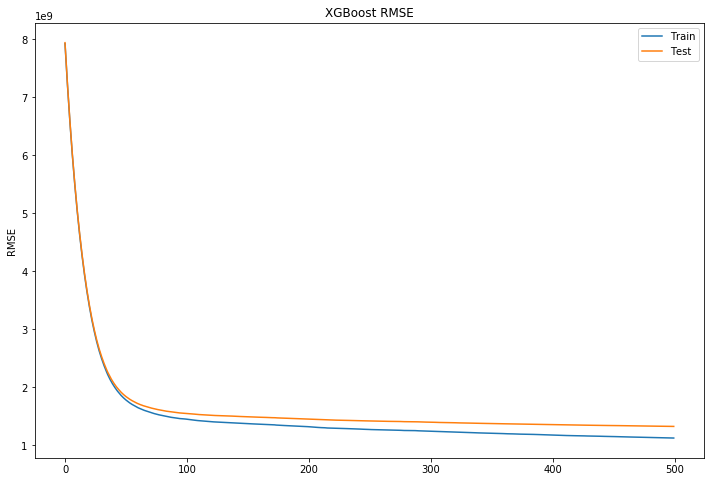

In [18]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

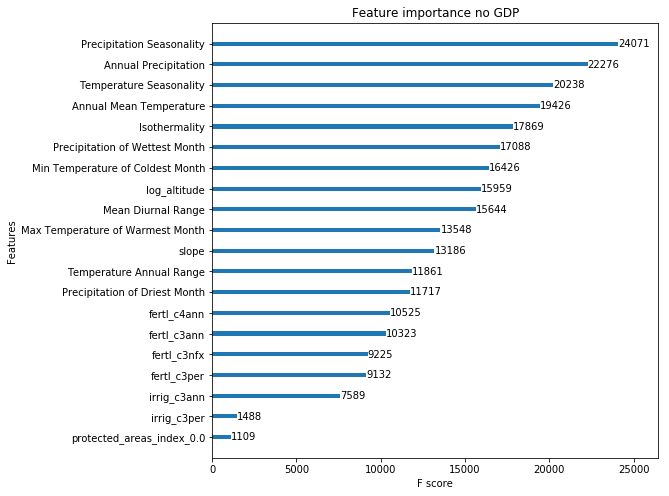

In [19]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax, grid=False, title='Feature importance no GDP')
plt.show()

### GDP continuous

In [20]:
X, y = df_2000_cont.drop(['calories_per_ha'], axis=1), df_2000_cont['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col_2)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [22]:
try: 
    model = pickle.load(open('data/models/' + 'gdp_continuous.sav', 'rb'))
except: 
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'gdp_continuous.sav', 'wb'))

[0]	validation_0-rmse:7.92018e+09	validation_1-rmse:7.93837e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.55549e+09	validation_1-rmse:7.57256e+09
[2]	validation_0-rmse:7.21016e+09	validation_1-rmse:7.22712e+09
[3]	validation_0-rmse:6.87937e+09	validation_1-rmse:6.89669e+09
[4]	validation_0-rmse:6.56958e+09	validation_1-rmse:6.58641e+09
[5]	validation_0-rmse:6.27314e+09	validation_1-rmse:6.29047e+09
[6]	validation_0-rmse:5.99217e+09	validation_1-rmse:6.00977e+09
[7]	validation_0-rmse:5.72827e+09	validation_1-rmse:5.74594e+09
[8]	validation_0-rmse:5.48153e+09	validation_1-rmse:5.49902e+09
[9]	validation_0-rmse:5.2434e+09	validation_1-rmse:5.26117e+09
[10]	validation_0-rmse:5.01926e+09	validation_1-rmse:5.0378e+09
[11]	validation_0-rmse:4.80513e+09	validation_1-rmse:4.8244e+09
[12]	validation_0-rmse:4.60686e+09	validation_1-rmse:4.62633e+09
[13]	vali

[124]	validation_0-rmse:1.33993e+09	validation_1-rmse:1.45669e+09
[125]	validation_0-rmse:1.33912e+09	validation_1-rmse:1.45607e+09
[126]	validation_0-rmse:1.33842e+09	validation_1-rmse:1.45557e+09
[127]	validation_0-rmse:1.33804e+09	validation_1-rmse:1.45526e+09
[128]	validation_0-rmse:1.33699e+09	validation_1-rmse:1.45439e+09
[129]	validation_0-rmse:1.33622e+09	validation_1-rmse:1.45393e+09
[130]	validation_0-rmse:1.33512e+09	validation_1-rmse:1.45307e+09
[131]	validation_0-rmse:1.33376e+09	validation_1-rmse:1.45212e+09
[132]	validation_0-rmse:1.33289e+09	validation_1-rmse:1.45153e+09
[133]	validation_0-rmse:1.33244e+09	validation_1-rmse:1.45118e+09
[134]	validation_0-rmse:1.33202e+09	validation_1-rmse:1.45083e+09
[135]	validation_0-rmse:1.33108e+09	validation_1-rmse:1.45013e+09
[136]	validation_0-rmse:1.32992e+09	validation_1-rmse:1.4493e+09
[137]	validation_0-rmse:1.32952e+09	validation_1-rmse:1.4491e+09
[138]	validation_0-rmse:1.32866e+09	validation_1-rmse:1.44846e+09
[139]	valida

[249]	validation_0-rmse:1.22691e+09	validation_1-rmse:1.37491e+09
[250]	validation_0-rmse:1.22674e+09	validation_1-rmse:1.37481e+09
[251]	validation_0-rmse:1.22626e+09	validation_1-rmse:1.37455e+09
[252]	validation_0-rmse:1.22464e+09	validation_1-rmse:1.37323e+09
[253]	validation_0-rmse:1.22412e+09	validation_1-rmse:1.37282e+09
[254]	validation_0-rmse:1.22386e+09	validation_1-rmse:1.3727e+09
[255]	validation_0-rmse:1.22293e+09	validation_1-rmse:1.3721e+09
[256]	validation_0-rmse:1.22251e+09	validation_1-rmse:1.37179e+09
[257]	validation_0-rmse:1.22211e+09	validation_1-rmse:1.37153e+09
[258]	validation_0-rmse:1.22158e+09	validation_1-rmse:1.37114e+09
[259]	validation_0-rmse:1.22006e+09	validation_1-rmse:1.37007e+09
[260]	validation_0-rmse:1.21903e+09	validation_1-rmse:1.36939e+09
[261]	validation_0-rmse:1.21764e+09	validation_1-rmse:1.36846e+09
[262]	validation_0-rmse:1.21749e+09	validation_1-rmse:1.36834e+09
[263]	validation_0-rmse:1.21726e+09	validation_1-rmse:1.36823e+09
[264]	valida

[374]	validation_0-rmse:1.14678e+09	validation_1-rmse:1.3226e+09
[375]	validation_0-rmse:1.14619e+09	validation_1-rmse:1.32218e+09
[376]	validation_0-rmse:1.14547e+09	validation_1-rmse:1.32176e+09
[377]	validation_0-rmse:1.14525e+09	validation_1-rmse:1.32176e+09
[378]	validation_0-rmse:1.14485e+09	validation_1-rmse:1.3215e+09
[379]	validation_0-rmse:1.14459e+09	validation_1-rmse:1.32136e+09
[380]	validation_0-rmse:1.14321e+09	validation_1-rmse:1.32041e+09
[381]	validation_0-rmse:1.14253e+09	validation_1-rmse:1.31986e+09
[382]	validation_0-rmse:1.14234e+09	validation_1-rmse:1.31978e+09
[383]	validation_0-rmse:1.14222e+09	validation_1-rmse:1.31975e+09
[384]	validation_0-rmse:1.14207e+09	validation_1-rmse:1.31966e+09
[385]	validation_0-rmse:1.14148e+09	validation_1-rmse:1.31928e+09
[386]	validation_0-rmse:1.14094e+09	validation_1-rmse:1.31899e+09
[387]	validation_0-rmse:1.14056e+09	validation_1-rmse:1.31871e+09
[388]	validation_0-rmse:1.14045e+09	validation_1-rmse:1.31873e+09
[389]	valida

[499]	validation_0-rmse:1.09341e+09	validation_1-rmse:1.28987e+09


In [23]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9199914497573207


In [24]:
results_df = results_df.append({'Model':'gdp_continuous',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse},ignore_index=True)

In [25]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

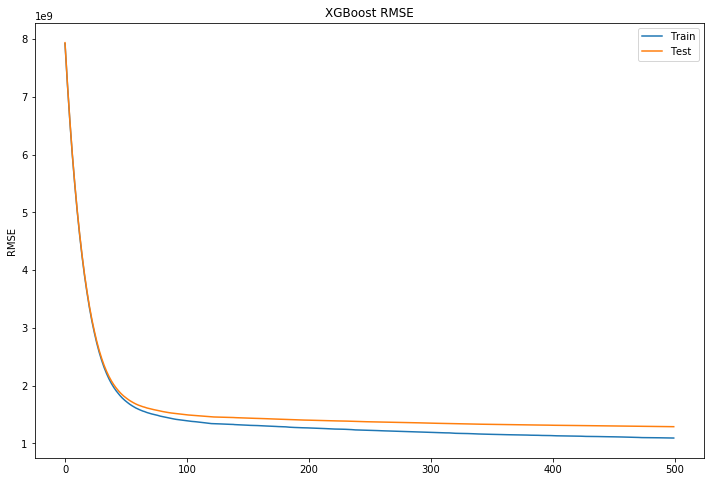

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

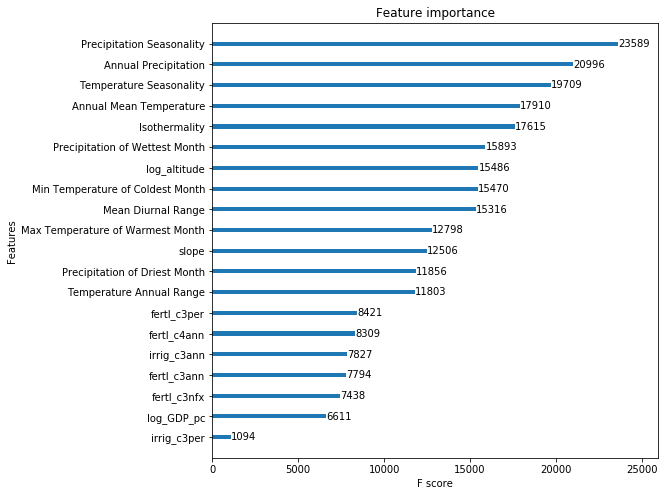

In [27]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax, grid=False)
plt.show()

In [28]:
X, y = df_2000.drop(['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [30]:
try:
    model = pickle.load(open('data/models/' + 'gdp_cat_stat.sav', 'rb'))
except:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'gdp_cat_stat.sav', 'wb'))

[0]	validation_0-rmse:7.92379e+09	validation_1-rmse:7.94302e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.56105e+09	validation_1-rmse:7.57883e+09
[2]	validation_0-rmse:7.21686e+09	validation_1-rmse:7.23489e+09
[3]	validation_0-rmse:6.89045e+09	validation_1-rmse:6.90846e+09
[4]	validation_0-rmse:6.5799e+09	validation_1-rmse:6.59773e+09
[5]	validation_0-rmse:6.28583e+09	validation_1-rmse:6.30399e+09
[6]	validation_0-rmse:6.0089e+09	validation_1-rmse:6.02694e+09
[7]	validation_0-rmse:5.74562e+09	validation_1-rmse:5.76386e+09
[8]	validation_0-rmse:5.49561e+09	validation_1-rmse:5.51419e+09
[9]	validation_0-rmse:5.26089e+09	validation_1-rmse:5.27975e+09
[10]	validation_0-rmse:5.03725e+09	validation_1-rmse:5.05717e+09
[11]	validation_0-rmse:4.82541e+09	validation_1-rmse:4.84532e+09
[12]	validation_0-rmse:4.62406e+09	validation_1-rmse:4.64462e+09
[13]	val

[124]	validation_0-rmse:1.3968e+09	validation_1-rmse:1.50572e+09
[125]	validation_0-rmse:1.39517e+09	validation_1-rmse:1.50457e+09
[126]	validation_0-rmse:1.3942e+09	validation_1-rmse:1.5038e+09
[127]	validation_0-rmse:1.39282e+09	validation_1-rmse:1.50266e+09
[128]	validation_0-rmse:1.39162e+09	validation_1-rmse:1.50166e+09
[129]	validation_0-rmse:1.39034e+09	validation_1-rmse:1.50072e+09
[130]	validation_0-rmse:1.38852e+09	validation_1-rmse:1.49938e+09
[131]	validation_0-rmse:1.38758e+09	validation_1-rmse:1.49867e+09
[132]	validation_0-rmse:1.38678e+09	validation_1-rmse:1.49818e+09
[133]	validation_0-rmse:1.38548e+09	validation_1-rmse:1.49728e+09
[134]	validation_0-rmse:1.38486e+09	validation_1-rmse:1.49685e+09
[135]	validation_0-rmse:1.38343e+09	validation_1-rmse:1.49569e+09
[136]	validation_0-rmse:1.38273e+09	validation_1-rmse:1.49514e+09
[137]	validation_0-rmse:1.38213e+09	validation_1-rmse:1.49471e+09
[138]	validation_0-rmse:1.38119e+09	validation_1-rmse:1.49402e+09
[139]	validat

[249]	validation_0-rmse:1.27002e+09	validation_1-rmse:1.41131e+09
[250]	validation_0-rmse:1.26978e+09	validation_1-rmse:1.41116e+09
[251]	validation_0-rmse:1.26878e+09	validation_1-rmse:1.41044e+09
[252]	validation_0-rmse:1.26806e+09	validation_1-rmse:1.40991e+09
[253]	validation_0-rmse:1.26782e+09	validation_1-rmse:1.40978e+09
[254]	validation_0-rmse:1.2664e+09	validation_1-rmse:1.40881e+09
[255]	validation_0-rmse:1.26622e+09	validation_1-rmse:1.40872e+09
[256]	validation_0-rmse:1.2658e+09	validation_1-rmse:1.40842e+09
[257]	validation_0-rmse:1.26449e+09	validation_1-rmse:1.40746e+09
[258]	validation_0-rmse:1.2619e+09	validation_1-rmse:1.40563e+09
[259]	validation_0-rmse:1.26138e+09	validation_1-rmse:1.40526e+09
[260]	validation_0-rmse:1.26094e+09	validation_1-rmse:1.40486e+09
[261]	validation_0-rmse:1.26086e+09	validation_1-rmse:1.40482e+09
[262]	validation_0-rmse:1.25979e+09	validation_1-rmse:1.40392e+09
[263]	validation_0-rmse:1.25912e+09	validation_1-rmse:1.40342e+09
[264]	validat

[374]	validation_0-rmse:1.18144e+09	validation_1-rmse:1.35154e+09
[375]	validation_0-rmse:1.18115e+09	validation_1-rmse:1.35132e+09
[376]	validation_0-rmse:1.18075e+09	validation_1-rmse:1.35113e+09
[377]	validation_0-rmse:1.18047e+09	validation_1-rmse:1.35093e+09
[378]	validation_0-rmse:1.17975e+09	validation_1-rmse:1.35042e+09
[379]	validation_0-rmse:1.17896e+09	validation_1-rmse:1.35007e+09
[380]	validation_0-rmse:1.17753e+09	validation_1-rmse:1.34936e+09
[381]	validation_0-rmse:1.17744e+09	validation_1-rmse:1.34932e+09
[382]	validation_0-rmse:1.17716e+09	validation_1-rmse:1.34914e+09
[383]	validation_0-rmse:1.17703e+09	validation_1-rmse:1.34906e+09
[384]	validation_0-rmse:1.17612e+09	validation_1-rmse:1.34843e+09
[385]	validation_0-rmse:1.17505e+09	validation_1-rmse:1.34779e+09
[386]	validation_0-rmse:1.17442e+09	validation_1-rmse:1.34749e+09
[387]	validation_0-rmse:1.17424e+09	validation_1-rmse:1.34738e+09
[388]	validation_0-rmse:1.17402e+09	validation_1-rmse:1.3472e+09
[389]	valid

[499]	validation_0-rmse:1.11566e+09	validation_1-rmse:1.31306e+09


In [31]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
mse = mean_squared_error(y_test, y_pred)

R2 score: 0.9170881085028902


In [32]:
results_df = results_df.append({'Model':'gdp_cat_stat',
                                'Validation_R2':r2,
                                'Validation_MSE': mse},ignore_index=True)

In [33]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

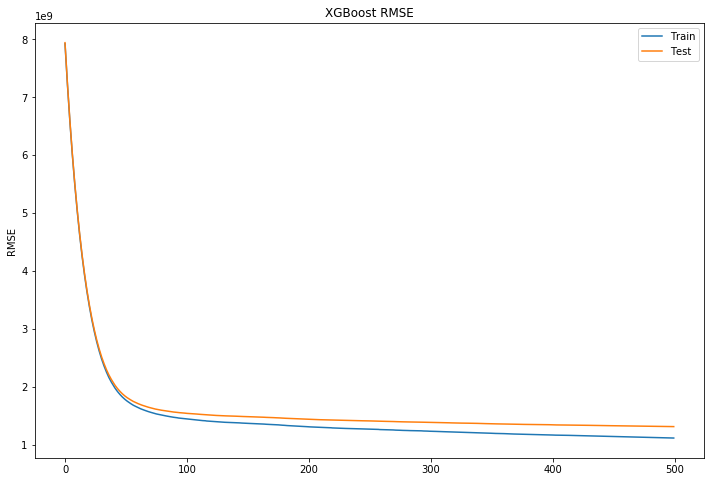

In [34]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

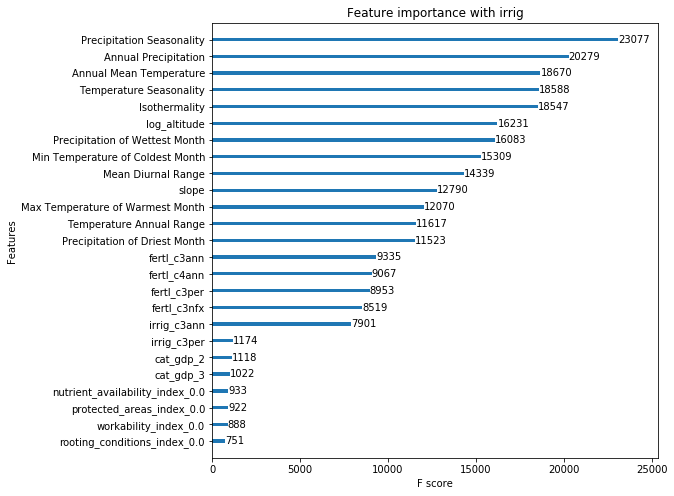

In [35]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=25, ax=ax, grid=False, title='Feature importance with irrig')
#plt.savefig(figure_path + 'feature_importance_irrig.png')
plt.show()

### GDP categorical (income level)

In [97]:
df_2000_income = pd.read_csv(inputs_path + 'normalized_2000_gdp_cat.csv', index_col='pixel_id', na_values=[-9999]).drop(['log_GDP_pc'], axis=1)

X, y = df_2000_income.drop(['calories_per_ha'], axis=1), df_2000_income['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X, label=y)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [99]:
try:
    model = pickle.load(open('data/models/' + 'gdp_cat_income.sav', 'rb'))
except:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'gdp_cat_income.sav', 'wb'))

[0]	validation_0-rmse:7.92424e+09	validation_1-rmse:7.94236e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.5602e+09	validation_1-rmse:7.57749e+09
[2]	validation_0-rmse:7.21572e+09	validation_1-rmse:7.23228e+09
[3]	validation_0-rmse:6.8901e+09	validation_1-rmse:6.90691e+09
[4]	validation_0-rmse:6.58078e+09	validation_1-rmse:6.59787e+09
[5]	validation_0-rmse:6.28696e+09	validation_1-rmse:6.30432e+09
[6]	validation_0-rmse:6.01026e+09	validation_1-rmse:6.02766e+09
[7]	validation_0-rmse:5.7453e+09	validation_1-rmse:5.76265e+09
[8]	validation_0-rmse:5.50221e+09	validation_1-rmse:5.52017e+09
[9]	validation_0-rmse:5.26653e+09	validation_1-rmse:5.2851e+09
[10]	validation_0-rmse:5.04175e+09	validation_1-rmse:5.06085e+09
[11]	validation_0-rmse:4.82988e+09	validation_1-rmse:4.84925e+09
[12]	validation_0-rmse:4.63019e+09	validation_1-rmse:4.64993e+09
[13]	valid

[124]	validation_0-rmse:1.40121e+09	validation_1-rmse:1.51425e+09
[125]	validation_0-rmse:1.40012e+09	validation_1-rmse:1.51332e+09
[126]	validation_0-rmse:1.39914e+09	validation_1-rmse:1.51253e+09
[127]	validation_0-rmse:1.39813e+09	validation_1-rmse:1.51181e+09
[128]	validation_0-rmse:1.3974e+09	validation_1-rmse:1.51125e+09
[129]	validation_0-rmse:1.39575e+09	validation_1-rmse:1.50993e+09
[130]	validation_0-rmse:1.3945e+09	validation_1-rmse:1.50908e+09
[131]	validation_0-rmse:1.39358e+09	validation_1-rmse:1.50844e+09
[132]	validation_0-rmse:1.3919e+09	validation_1-rmse:1.50725e+09
[133]	validation_0-rmse:1.3911e+09	validation_1-rmse:1.50665e+09
[134]	validation_0-rmse:1.39024e+09	validation_1-rmse:1.50602e+09
[135]	validation_0-rmse:1.38848e+09	validation_1-rmse:1.50474e+09
[136]	validation_0-rmse:1.38778e+09	validation_1-rmse:1.50411e+09
[137]	validation_0-rmse:1.38654e+09	validation_1-rmse:1.50315e+09
[138]	validation_0-rmse:1.38575e+09	validation_1-rmse:1.50255e+09
[139]	validati

[249]	validation_0-rmse:1.27341e+09	validation_1-rmse:1.42219e+09
[250]	validation_0-rmse:1.27231e+09	validation_1-rmse:1.42144e+09
[251]	validation_0-rmse:1.27157e+09	validation_1-rmse:1.42099e+09
[252]	validation_0-rmse:1.27042e+09	validation_1-rmse:1.42016e+09
[253]	validation_0-rmse:1.27013e+09	validation_1-rmse:1.41997e+09
[254]	validation_0-rmse:1.26852e+09	validation_1-rmse:1.4189e+09
[255]	validation_0-rmse:1.26832e+09	validation_1-rmse:1.41873e+09
[256]	validation_0-rmse:1.26816e+09	validation_1-rmse:1.41861e+09
[257]	validation_0-rmse:1.26686e+09	validation_1-rmse:1.41771e+09
[258]	validation_0-rmse:1.26553e+09	validation_1-rmse:1.41669e+09
[259]	validation_0-rmse:1.26523e+09	validation_1-rmse:1.4166e+09
[260]	validation_0-rmse:1.2648e+09	validation_1-rmse:1.41629e+09
[261]	validation_0-rmse:1.2637e+09	validation_1-rmse:1.41543e+09
[262]	validation_0-rmse:1.26348e+09	validation_1-rmse:1.41528e+09
[263]	validation_0-rmse:1.26307e+09	validation_1-rmse:1.415e+09
[264]	validation

[374]	validation_0-rmse:1.18456e+09	validation_1-rmse:1.36394e+09
[375]	validation_0-rmse:1.18411e+09	validation_1-rmse:1.36368e+09
[376]	validation_0-rmse:1.18387e+09	validation_1-rmse:1.36355e+09
[377]	validation_0-rmse:1.18295e+09	validation_1-rmse:1.36288e+09
[378]	validation_0-rmse:1.18199e+09	validation_1-rmse:1.3622e+09
[379]	validation_0-rmse:1.18174e+09	validation_1-rmse:1.36204e+09
[380]	validation_0-rmse:1.18092e+09	validation_1-rmse:1.36144e+09
[381]	validation_0-rmse:1.18007e+09	validation_1-rmse:1.36089e+09
[382]	validation_0-rmse:1.17862e+09	validation_1-rmse:1.35999e+09
[383]	validation_0-rmse:1.17821e+09	validation_1-rmse:1.35972e+09
[384]	validation_0-rmse:1.17734e+09	validation_1-rmse:1.35927e+09
[385]	validation_0-rmse:1.1767e+09	validation_1-rmse:1.35885e+09
[386]	validation_0-rmse:1.17599e+09	validation_1-rmse:1.35849e+09
[387]	validation_0-rmse:1.17552e+09	validation_1-rmse:1.35822e+09
[388]	validation_0-rmse:1.17502e+09	validation_1-rmse:1.35794e+09
[389]	valida

[499]	validation_0-rmse:1.11828e+09	validation_1-rmse:1.32256e+09


In [100]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9158848875959392


In [101]:
results_df = results_df.append({'Model':'gdp_cat_income',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse},ignore_index=True)

In [102]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

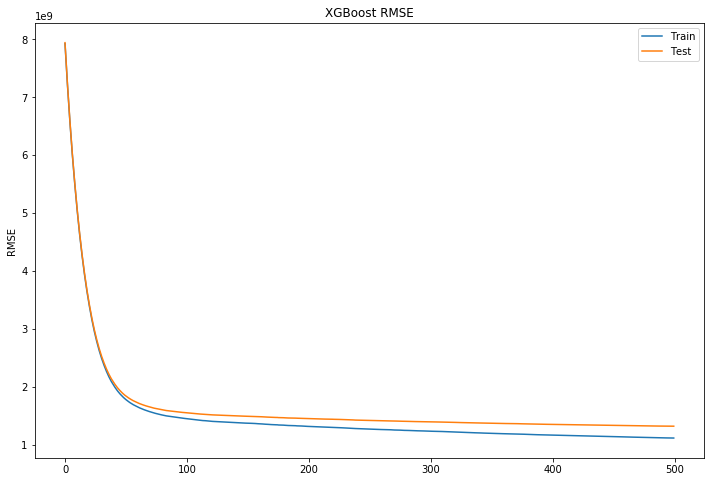

In [103]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

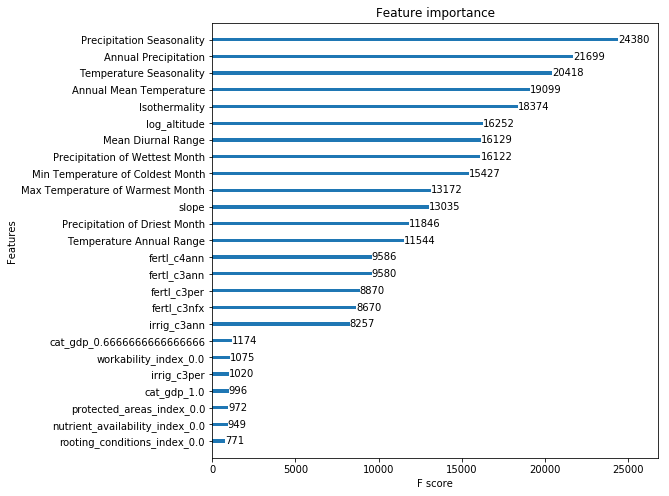

In [104]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=25, ax=ax, grid=False, title='Feature importance')
#plt.savefig(figure_path + 'feature_importance_irrig.png')
plt.show()

### GDP categorical (statistical data)

In [46]:
X, y = df_2000.drop(['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [48]:
try:
    model = pickle.load(open('data/models/' + 'gdp_cat_stat.sav', 'rb'))
except:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'gdp_cat_stat.sav', 'wb'))

In [49]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9170881085028902


In [50]:
results_df = results_df.append({'Model':'gdp_cat_stat',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse}, ignore_index=True)

In [51]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

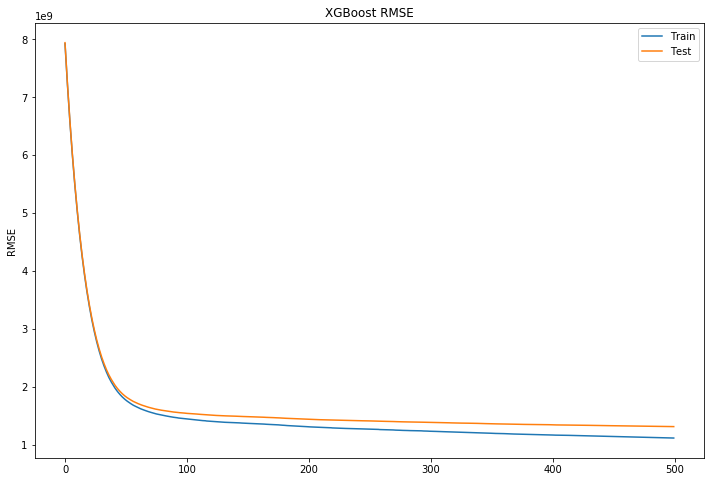

In [52]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

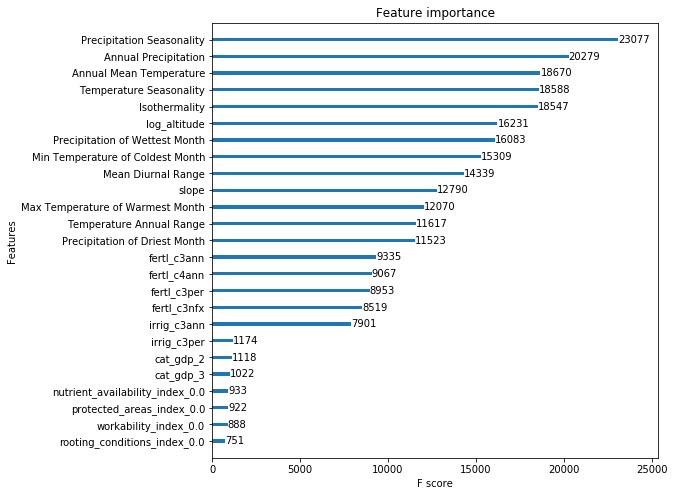

In [53]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=25, ax=ax, grid=False, title='Feature importance')
#plt.savefig(figure_path + 'feature_importance_irrig.png')
plt.show()

## Climate

In [54]:
col_to_drop = ['Annual Mean Temperature', 'Mean Diurnal Range',
               'Isothermality', 'Temperature Seasonality',
               'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
               'Temperature Annual Range', 'Annual Precipitation',
               'Precipitation of Wettest Month', 'Precipitation of Driest Month',
               'Precipitation Seasonality']

In [55]:
X, y = df_2000.drop(col_to_drop + ['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X, label=y)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [57]:
try: 
    model = pickle.load(open('data/models/' + 'no_climate.sav', 'rb'))
except:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'no_climate.sav', 'wb'))

[0]	validation_0-rmse:7.93307e+09	validation_1-rmse:7.95119e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.57986e+09	validation_1-rmse:7.59777e+09
[2]	validation_0-rmse:7.24433e+09	validation_1-rmse:7.2621e+09
[3]	validation_0-rmse:6.92731e+09	validation_1-rmse:6.94504e+09
[4]	validation_0-rmse:6.62677e+09	validation_1-rmse:6.64515e+09
[5]	validation_0-rmse:6.34303e+09	validation_1-rmse:6.36208e+09
[6]	validation_0-rmse:6.07564e+09	validation_1-rmse:6.09463e+09
[7]	validation_0-rmse:5.82799e+09	validation_1-rmse:5.84722e+09
[8]	validation_0-rmse:5.58991e+09	validation_1-rmse:5.61008e+09
[9]	validation_0-rmse:5.36606e+09	validation_1-rmse:5.38639e+09
[10]	validation_0-rmse:5.15808e+09	validation_1-rmse:5.17871e+09
[11]	validation_0-rmse:4.95918e+09	validation_1-rmse:4.98e+09
[12]	validation_0-rmse:4.7721e+09	validation_1-rmse:4.79335e+09
[13]	valida

[124]	validation_0-rmse:2.12232e+09	validation_1-rmse:2.19686e+09
[125]	validation_0-rmse:2.12188e+09	validation_1-rmse:2.19664e+09
[126]	validation_0-rmse:2.121e+09	validation_1-rmse:2.19593e+09
[127]	validation_0-rmse:2.11964e+09	validation_1-rmse:2.19486e+09
[128]	validation_0-rmse:2.11897e+09	validation_1-rmse:2.19451e+09
[129]	validation_0-rmse:2.11834e+09	validation_1-rmse:2.19408e+09
[130]	validation_0-rmse:2.1179e+09	validation_1-rmse:2.19382e+09
[131]	validation_0-rmse:2.11708e+09	validation_1-rmse:2.1933e+09
[132]	validation_0-rmse:2.11638e+09	validation_1-rmse:2.19281e+09
[133]	validation_0-rmse:2.11543e+09	validation_1-rmse:2.19222e+09
[134]	validation_0-rmse:2.1148e+09	validation_1-rmse:2.19177e+09
[135]	validation_0-rmse:2.11442e+09	validation_1-rmse:2.19151e+09
[136]	validation_0-rmse:2.11293e+09	validation_1-rmse:2.19043e+09
[137]	validation_0-rmse:2.11258e+09	validation_1-rmse:2.1902e+09
[138]	validation_0-rmse:2.11219e+09	validation_1-rmse:2.18991e+09
[139]	validation

[249]	validation_0-rmse:2.04685e+09	validation_1-rmse:2.14992e+09
[250]	validation_0-rmse:2.04613e+09	validation_1-rmse:2.1495e+09
[251]	validation_0-rmse:2.04608e+09	validation_1-rmse:2.14947e+09
[252]	validation_0-rmse:2.04598e+09	validation_1-rmse:2.14943e+09
[253]	validation_0-rmse:2.04497e+09	validation_1-rmse:2.14881e+09
[254]	validation_0-rmse:2.04482e+09	validation_1-rmse:2.1487e+09
[255]	validation_0-rmse:2.04421e+09	validation_1-rmse:2.14841e+09
[256]	validation_0-rmse:2.04398e+09	validation_1-rmse:2.14826e+09
[257]	validation_0-rmse:2.04389e+09	validation_1-rmse:2.14824e+09
[258]	validation_0-rmse:2.04379e+09	validation_1-rmse:2.14818e+09
[259]	validation_0-rmse:2.04344e+09	validation_1-rmse:2.14797e+09
[260]	validation_0-rmse:2.04342e+09	validation_1-rmse:2.14797e+09
[261]	validation_0-rmse:2.04318e+09	validation_1-rmse:2.14785e+09
[262]	validation_0-rmse:2.04262e+09	validation_1-rmse:2.14744e+09
[263]	validation_0-rmse:2.04231e+09	validation_1-rmse:2.14729e+09
[264]	valida

[374]	validation_0-rmse:2.00994e+09	validation_1-rmse:2.13081e+09
[375]	validation_0-rmse:2.0097e+09	validation_1-rmse:2.13074e+09
[376]	validation_0-rmse:2.00967e+09	validation_1-rmse:2.13073e+09
[377]	validation_0-rmse:2.0095e+09	validation_1-rmse:2.13064e+09
[378]	validation_0-rmse:2.00871e+09	validation_1-rmse:2.13019e+09
[379]	validation_0-rmse:2.00859e+09	validation_1-rmse:2.1301e+09
[380]	validation_0-rmse:2.00805e+09	validation_1-rmse:2.12983e+09
[381]	validation_0-rmse:2.00783e+09	validation_1-rmse:2.12973e+09
[382]	validation_0-rmse:2.00778e+09	validation_1-rmse:2.1297e+09
[383]	validation_0-rmse:2.00763e+09	validation_1-rmse:2.1297e+09
[384]	validation_0-rmse:2.00751e+09	validation_1-rmse:2.12966e+09
[385]	validation_0-rmse:2.00647e+09	validation_1-rmse:2.12893e+09
[386]	validation_0-rmse:2.00622e+09	validation_1-rmse:2.12881e+09
[387]	validation_0-rmse:2.00611e+09	validation_1-rmse:2.12875e+09
[388]	validation_0-rmse:2.006e+09	validation_1-rmse:2.12869e+09
[389]	validation_

[499]	validation_0-rmse:1.97707e+09	validation_1-rmse:2.11532e+09


In [58]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.7848225437850869


In [59]:
results_df = results_df.append({'Model':'no_climate',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse},ignore_index=True)

In [60]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

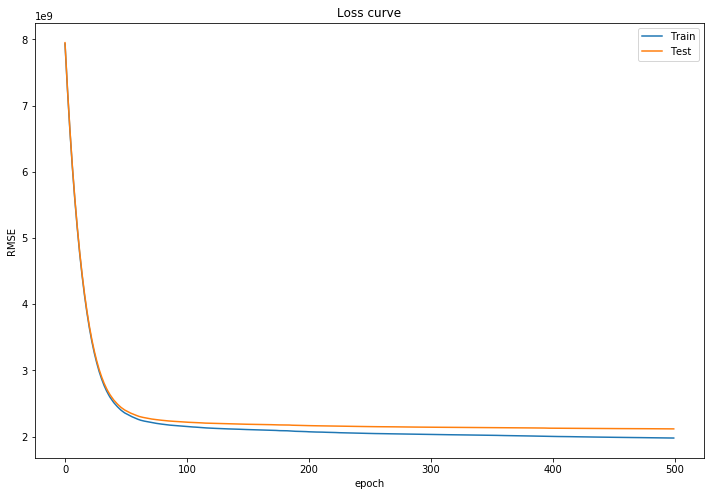

In [61]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Loss curve')
plt.savefig(figure_path + 'no_irrig.png', dpi=500)

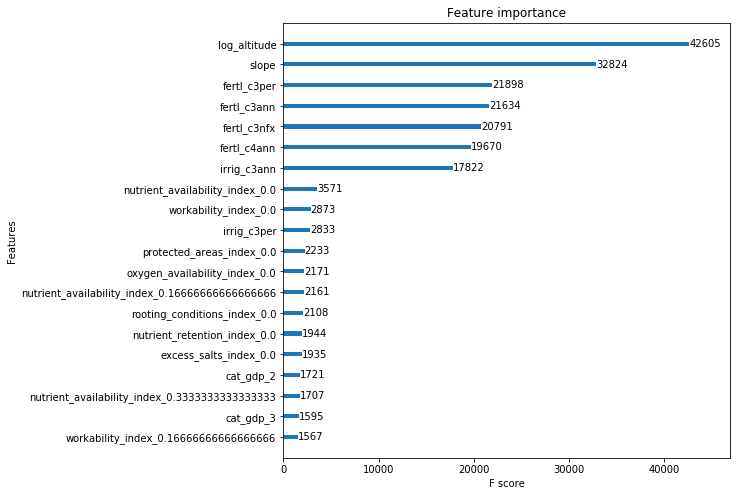

In [62]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax, grid=False, title='Feature importance')
#plt.savefig(figure_path + 'feature_importance_no_irrig.png', dpi=500)
plt.show()

## Irrigation

In [63]:
col_to_drop = ['irrig_c3ann', 'irrig_c3per', 'irrig_c3nfx', 'irrig_c4ann', 'irrig_c4per']

In [64]:
X, y = df_2000.drop(col_to_drop + ['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [66]:
try: 
    model = pickle.load(open('data/models/' + 'no_irrig.sav', 'rb'))
except:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'no_irrig.sav', 'wb'))

[0]	validation_0-rmse:7.92273e+09	validation_1-rmse:7.94119e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.56137e+09	validation_1-rmse:7.57856e+09
[2]	validation_0-rmse:7.21678e+09	validation_1-rmse:7.23447e+09
[3]	validation_0-rmse:6.88821e+09	validation_1-rmse:6.90678e+09
[4]	validation_0-rmse:6.58048e+09	validation_1-rmse:6.59899e+09
[5]	validation_0-rmse:6.28667e+09	validation_1-rmse:6.30598e+09
[6]	validation_0-rmse:6.00951e+09	validation_1-rmse:6.02817e+09
[7]	validation_0-rmse:5.74637e+09	validation_1-rmse:5.76499e+09
[8]	validation_0-rmse:5.4981e+09	validation_1-rmse:5.51669e+09
[9]	validation_0-rmse:5.26216e+09	validation_1-rmse:5.28114e+09
[10]	validation_0-rmse:5.03935e+09	validation_1-rmse:5.05895e+09
[11]	validation_0-rmse:4.8293e+09	validation_1-rmse:4.84926e+09
[12]	validation_0-rmse:4.63077e+09	validation_1-rmse:4.65116e+09
[13]	val

[124]	validation_0-rmse:1.41435e+09	validation_1-rmse:1.52045e+09
[125]	validation_0-rmse:1.41178e+09	validation_1-rmse:1.51831e+09
[126]	validation_0-rmse:1.41061e+09	validation_1-rmse:1.51752e+09
[127]	validation_0-rmse:1.40656e+09	validation_1-rmse:1.51482e+09
[128]	validation_0-rmse:1.40525e+09	validation_1-rmse:1.51396e+09
[129]	validation_0-rmse:1.40392e+09	validation_1-rmse:1.51283e+09
[130]	validation_0-rmse:1.40242e+09	validation_1-rmse:1.51177e+09
[131]	validation_0-rmse:1.40121e+09	validation_1-rmse:1.51078e+09
[132]	validation_0-rmse:1.40039e+09	validation_1-rmse:1.51022e+09
[133]	validation_0-rmse:1.39928e+09	validation_1-rmse:1.5094e+09
[134]	validation_0-rmse:1.3986e+09	validation_1-rmse:1.50894e+09
[135]	validation_0-rmse:1.39769e+09	validation_1-rmse:1.50825e+09
[136]	validation_0-rmse:1.39695e+09	validation_1-rmse:1.50771e+09
[137]	validation_0-rmse:1.3961e+09	validation_1-rmse:1.507e+09
[138]	validation_0-rmse:1.39473e+09	validation_1-rmse:1.50592e+09
[139]	validatio

[249]	validation_0-rmse:1.28562e+09	validation_1-rmse:1.42591e+09
[250]	validation_0-rmse:1.28545e+09	validation_1-rmse:1.42578e+09
[251]	validation_0-rmse:1.28507e+09	validation_1-rmse:1.42551e+09
[252]	validation_0-rmse:1.28479e+09	validation_1-rmse:1.4254e+09
[253]	validation_0-rmse:1.28448e+09	validation_1-rmse:1.42515e+09
[254]	validation_0-rmse:1.28326e+09	validation_1-rmse:1.42434e+09
[255]	validation_0-rmse:1.28298e+09	validation_1-rmse:1.42411e+09
[256]	validation_0-rmse:1.28122e+09	validation_1-rmse:1.42272e+09
[257]	validation_0-rmse:1.28041e+09	validation_1-rmse:1.42213e+09
[258]	validation_0-rmse:1.27846e+09	validation_1-rmse:1.421e+09
[259]	validation_0-rmse:1.27727e+09	validation_1-rmse:1.42012e+09
[260]	validation_0-rmse:1.27541e+09	validation_1-rmse:1.41895e+09
[261]	validation_0-rmse:1.27451e+09	validation_1-rmse:1.4184e+09
[262]	validation_0-rmse:1.27374e+09	validation_1-rmse:1.41787e+09
[263]	validation_0-rmse:1.2734e+09	validation_1-rmse:1.41759e+09
[264]	validatio

[374]	validation_0-rmse:1.19803e+09	validation_1-rmse:1.36811e+09
[375]	validation_0-rmse:1.19743e+09	validation_1-rmse:1.36788e+09
[376]	validation_0-rmse:1.19725e+09	validation_1-rmse:1.36776e+09
[377]	validation_0-rmse:1.19675e+09	validation_1-rmse:1.36744e+09
[378]	validation_0-rmse:1.19663e+09	validation_1-rmse:1.36739e+09
[379]	validation_0-rmse:1.19594e+09	validation_1-rmse:1.36703e+09
[380]	validation_0-rmse:1.19588e+09	validation_1-rmse:1.36702e+09
[381]	validation_0-rmse:1.19582e+09	validation_1-rmse:1.367e+09
[382]	validation_0-rmse:1.19537e+09	validation_1-rmse:1.36675e+09
[383]	validation_0-rmse:1.19526e+09	validation_1-rmse:1.36671e+09
[384]	validation_0-rmse:1.19513e+09	validation_1-rmse:1.36663e+09
[385]	validation_0-rmse:1.19395e+09	validation_1-rmse:1.36602e+09
[386]	validation_0-rmse:1.19375e+09	validation_1-rmse:1.36591e+09
[387]	validation_0-rmse:1.19341e+09	validation_1-rmse:1.36568e+09
[388]	validation_0-rmse:1.19314e+09	validation_1-rmse:1.36553e+09
[389]	valida

[499]	validation_0-rmse:1.13066e+09	validation_1-rmse:1.32694e+09


In [67]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9153263550244837


In [68]:
results_df = results_df.append({'Model':'no_irrig',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse},ignore_index=True)

In [69]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

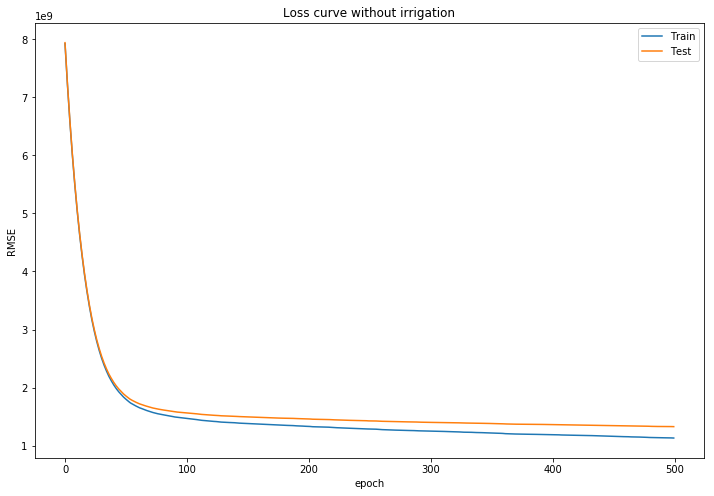

In [70]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Loss curve without irrigation')
plt.savefig(figure_path + 'no_irrig.png', dpi=500)

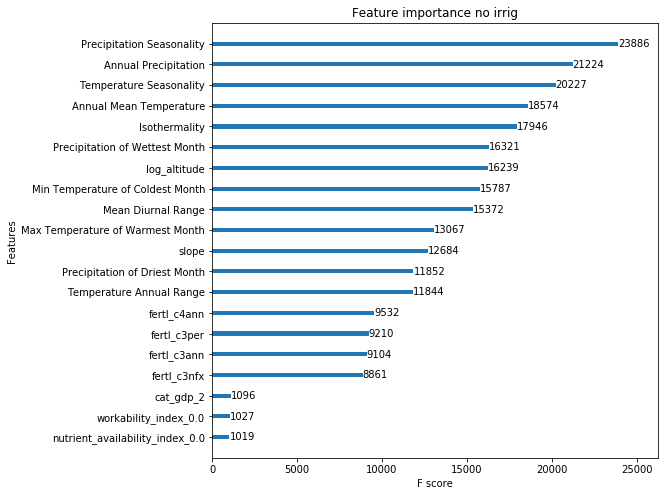

In [71]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax, grid=False, title='Feature importance no irrig')
#plt.savefig(figure_path + 'feature_importance_no_irrig.png', dpi=500)
plt.show()

## Fertilizers

In [74]:
col_to_drop = ['fertl_c3ann', 'fertl_c3per', 'fertl_c3nfx', 'fertl_c4ann']

In [75]:
X, y = df_2000.drop(col_to_drop + ['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [77]:
try: 
    model = pickle.load(open('data/models/' + 'no_fertl.sav', 'rb'))
except:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'no_fertl.sav', 'wb'))

[0]	validation_0-rmse:7.92807e+09	validation_1-rmse:7.94675e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.56862e+09	validation_1-rmse:7.58695e+09
[2]	validation_0-rmse:7.23024e+09	validation_1-rmse:7.24902e+09
[3]	validation_0-rmse:6.90903e+09	validation_1-rmse:6.92835e+09
[4]	validation_0-rmse:6.60364e+09	validation_1-rmse:6.62345e+09
[5]	validation_0-rmse:6.31444e+09	validation_1-rmse:6.3345e+09
[6]	validation_0-rmse:6.04344e+09	validation_1-rmse:6.06435e+09
[7]	validation_0-rmse:5.78424e+09	validation_1-rmse:5.80573e+09
[8]	validation_0-rmse:5.54385e+09	validation_1-rmse:5.56545e+09
[9]	validation_0-rmse:5.3093e+09	validation_1-rmse:5.33198e+09
[10]	validation_0-rmse:5.09046e+09	validation_1-rmse:5.1139e+09
[11]	validation_0-rmse:4.88243e+09	validation_1-rmse:4.90618e+09
[12]	validation_0-rmse:4.68776e+09	validation_1-rmse:4.71217e+09
[13]	vali

[124]	validation_0-rmse:1.55971e+09	validation_1-rmse:1.67149e+09
[125]	validation_0-rmse:1.55849e+09	validation_1-rmse:1.67037e+09
[126]	validation_0-rmse:1.55548e+09	validation_1-rmse:1.66835e+09
[127]	validation_0-rmse:1.55401e+09	validation_1-rmse:1.66706e+09
[128]	validation_0-rmse:1.55329e+09	validation_1-rmse:1.66648e+09
[129]	validation_0-rmse:1.55198e+09	validation_1-rmse:1.66543e+09
[130]	validation_0-rmse:1.55072e+09	validation_1-rmse:1.66434e+09
[131]	validation_0-rmse:1.55003e+09	validation_1-rmse:1.66387e+09
[132]	validation_0-rmse:1.54907e+09	validation_1-rmse:1.66315e+09
[133]	validation_0-rmse:1.54775e+09	validation_1-rmse:1.66203e+09
[134]	validation_0-rmse:1.54567e+09	validation_1-rmse:1.66068e+09
[135]	validation_0-rmse:1.54354e+09	validation_1-rmse:1.65913e+09
[136]	validation_0-rmse:1.5423e+09	validation_1-rmse:1.65811e+09
[137]	validation_0-rmse:1.54125e+09	validation_1-rmse:1.65731e+09
[138]	validation_0-rmse:1.54048e+09	validation_1-rmse:1.65668e+09
[139]	valid

[249]	validation_0-rmse:1.38549e+09	validation_1-rmse:1.53977e+09
[250]	validation_0-rmse:1.38501e+09	validation_1-rmse:1.53954e+09
[251]	validation_0-rmse:1.38414e+09	validation_1-rmse:1.53884e+09
[252]	validation_0-rmse:1.38307e+09	validation_1-rmse:1.53803e+09
[253]	validation_0-rmse:1.38152e+09	validation_1-rmse:1.5369e+09
[254]	validation_0-rmse:1.38049e+09	validation_1-rmse:1.53604e+09
[255]	validation_0-rmse:1.37901e+09	validation_1-rmse:1.535e+09
[256]	validation_0-rmse:1.37863e+09	validation_1-rmse:1.53476e+09
[257]	validation_0-rmse:1.37755e+09	validation_1-rmse:1.53397e+09
[258]	validation_0-rmse:1.37664e+09	validation_1-rmse:1.53356e+09
[259]	validation_0-rmse:1.37523e+09	validation_1-rmse:1.53259e+09
[260]	validation_0-rmse:1.37294e+09	validation_1-rmse:1.53099e+09
[261]	validation_0-rmse:1.37178e+09	validation_1-rmse:1.53016e+09
[262]	validation_0-rmse:1.37086e+09	validation_1-rmse:1.52932e+09
[263]	validation_0-rmse:1.36983e+09	validation_1-rmse:1.52869e+09
[264]	validat

[374]	validation_0-rmse:1.28095e+09	validation_1-rmse:1.47041e+09
[375]	validation_0-rmse:1.27964e+09	validation_1-rmse:1.46929e+09
[376]	validation_0-rmse:1.27872e+09	validation_1-rmse:1.46853e+09
[377]	validation_0-rmse:1.27832e+09	validation_1-rmse:1.4683e+09
[378]	validation_0-rmse:1.27773e+09	validation_1-rmse:1.46793e+09
[379]	validation_0-rmse:1.27702e+09	validation_1-rmse:1.46743e+09
[380]	validation_0-rmse:1.27587e+09	validation_1-rmse:1.46669e+09
[381]	validation_0-rmse:1.27497e+09	validation_1-rmse:1.46617e+09
[382]	validation_0-rmse:1.27491e+09	validation_1-rmse:1.46614e+09
[383]	validation_0-rmse:1.27458e+09	validation_1-rmse:1.46595e+09
[384]	validation_0-rmse:1.27454e+09	validation_1-rmse:1.46592e+09
[385]	validation_0-rmse:1.27422e+09	validation_1-rmse:1.4657e+09
[386]	validation_0-rmse:1.27388e+09	validation_1-rmse:1.46544e+09
[387]	validation_0-rmse:1.2732e+09	validation_1-rmse:1.46505e+09
[388]	validation_0-rmse:1.27272e+09	validation_1-rmse:1.46474e+09
[389]	validat

[499]	validation_0-rmse:1.21387e+09	validation_1-rmse:1.42799e+09


In [78]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9019391421422112


In [79]:
results_df = results_df.append({'Model':'no_fertl',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse},ignore_index=True)

In [80]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

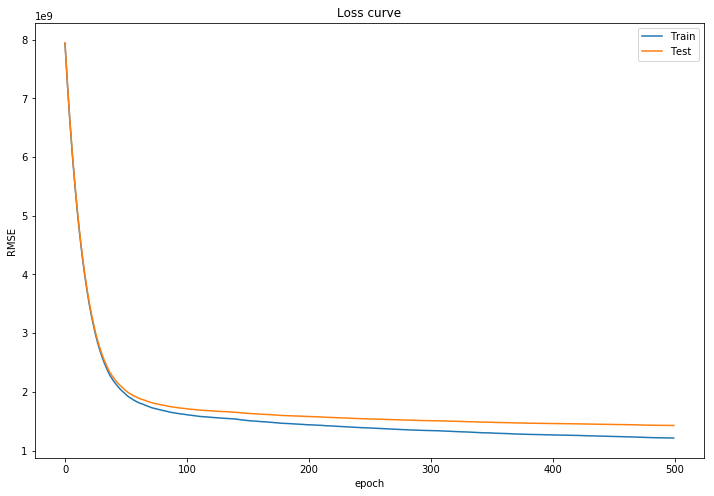

In [81]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Loss curve')
plt.savefig(figure_path + 'no_fertl.png', dpi=500)

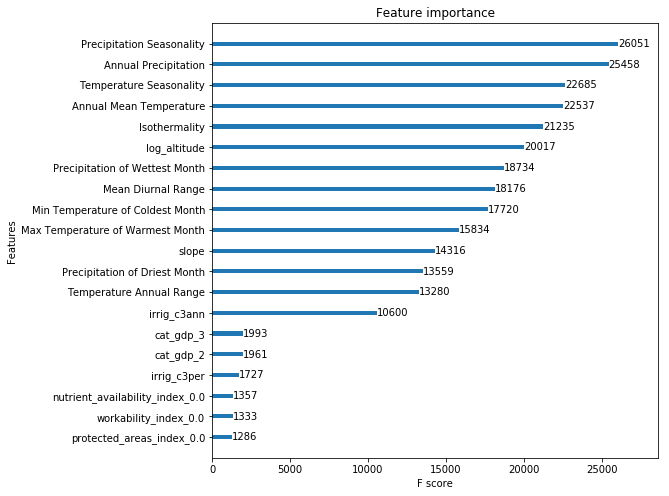

In [82]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax, grid=False, title='Feature importance')
#plt.savefig(figure_path + 'feature_importance_no_irrig.png', dpi=500)
plt.show()

## Soil indexes

In [83]:
col_to_drop = ['nutrient_availability_index',
               'oxygen_availability_index', 'workability_index',
               'protected_areas_index', 'nutrient_retention_index', 'toxicity_index',
               'excess_salts_index', 'rooting_conditions_index']

non_numerical_col_3 = [col for col in non_numerical_col if col not in col_to_drop]

In [84]:
X, y = df_2000.drop(col_to_drop + ['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col_3)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [86]:
try: 
    model = pickle.load(open('data/models/' + 'no_soil.sav', 'rb'))
except:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + 'no_soil.sav', 'wb'))

[0]	validation_0-rmse:7.92422e+09	validation_1-rmse:7.94278e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.5623e+09	validation_1-rmse:7.57953e+09
[2]	validation_0-rmse:7.21822e+09	validation_1-rmse:7.23549e+09
[3]	validation_0-rmse:6.89199e+09	validation_1-rmse:6.91082e+09
[4]	validation_0-rmse:6.58716e+09	validation_1-rmse:6.60466e+09
[5]	validation_0-rmse:6.29146e+09	validation_1-rmse:6.31031e+09
[6]	validation_0-rmse:6.01395e+09	validation_1-rmse:6.03246e+09
[7]	validation_0-rmse:5.75015e+09	validation_1-rmse:5.76906e+09
[8]	validation_0-rmse:5.50093e+09	validation_1-rmse:5.51997e+09
[9]	validation_0-rmse:5.26589e+09	validation_1-rmse:5.28512e+09
[10]	validation_0-rmse:5.04328e+09	validation_1-rmse:5.06287e+09
[11]	validation_0-rmse:4.83295e+09	validation_1-rmse:4.85288e+09
[12]	validation_0-rmse:4.63476e+09	validation_1-rmse:4.65538e+09
[13]	va

[124]	validation_0-rmse:1.40763e+09	validation_1-rmse:1.51645e+09
[125]	validation_0-rmse:1.40636e+09	validation_1-rmse:1.51556e+09
[126]	validation_0-rmse:1.40515e+09	validation_1-rmse:1.51471e+09
[127]	validation_0-rmse:1.40399e+09	validation_1-rmse:1.5139e+09
[128]	validation_0-rmse:1.40206e+09	validation_1-rmse:1.51239e+09
[129]	validation_0-rmse:1.40084e+09	validation_1-rmse:1.51142e+09
[130]	validation_0-rmse:1.39947e+09	validation_1-rmse:1.51032e+09
[131]	validation_0-rmse:1.39673e+09	validation_1-rmse:1.50824e+09
[132]	validation_0-rmse:1.3955e+09	validation_1-rmse:1.5074e+09
[133]	validation_0-rmse:1.39453e+09	validation_1-rmse:1.50669e+09
[134]	validation_0-rmse:1.39193e+09	validation_1-rmse:1.50466e+09
[135]	validation_0-rmse:1.39103e+09	validation_1-rmse:1.50408e+09
[136]	validation_0-rmse:1.39022e+09	validation_1-rmse:1.5036e+09
[137]	validation_0-rmse:1.38936e+09	validation_1-rmse:1.50297e+09
[138]	validation_0-rmse:1.38843e+09	validation_1-rmse:1.5023e+09
[139]	validatio

[249]	validation_0-rmse:1.27313e+09	validation_1-rmse:1.41926e+09
[250]	validation_0-rmse:1.27141e+09	validation_1-rmse:1.41806e+09
[251]	validation_0-rmse:1.27111e+09	validation_1-rmse:1.41787e+09
[252]	validation_0-rmse:1.27048e+09	validation_1-rmse:1.41735e+09
[253]	validation_0-rmse:1.2698e+09	validation_1-rmse:1.41679e+09
[254]	validation_0-rmse:1.26833e+09	validation_1-rmse:1.41572e+09
[255]	validation_0-rmse:1.26822e+09	validation_1-rmse:1.41568e+09
[256]	validation_0-rmse:1.26737e+09	validation_1-rmse:1.41502e+09
[257]	validation_0-rmse:1.26642e+09	validation_1-rmse:1.41432e+09
[258]	validation_0-rmse:1.26518e+09	validation_1-rmse:1.41344e+09
[259]	validation_0-rmse:1.26493e+09	validation_1-rmse:1.41331e+09
[260]	validation_0-rmse:1.26427e+09	validation_1-rmse:1.41279e+09
[261]	validation_0-rmse:1.26358e+09	validation_1-rmse:1.41237e+09
[262]	validation_0-rmse:1.26185e+09	validation_1-rmse:1.41122e+09
[263]	validation_0-rmse:1.26101e+09	validation_1-rmse:1.41058e+09
[264]	valid

[374]	validation_0-rmse:1.1869e+09	validation_1-rmse:1.36175e+09
[375]	validation_0-rmse:1.18662e+09	validation_1-rmse:1.36153e+09
[376]	validation_0-rmse:1.18563e+09	validation_1-rmse:1.36105e+09
[377]	validation_0-rmse:1.18486e+09	validation_1-rmse:1.36052e+09
[378]	validation_0-rmse:1.18395e+09	validation_1-rmse:1.35988e+09
[379]	validation_0-rmse:1.18338e+09	validation_1-rmse:1.35972e+09
[380]	validation_0-rmse:1.18286e+09	validation_1-rmse:1.35933e+09
[381]	validation_0-rmse:1.18202e+09	validation_1-rmse:1.35884e+09
[382]	validation_0-rmse:1.18069e+09	validation_1-rmse:1.35806e+09
[383]	validation_0-rmse:1.18016e+09	validation_1-rmse:1.35782e+09
[384]	validation_0-rmse:1.17891e+09	validation_1-rmse:1.35696e+09
[385]	validation_0-rmse:1.17828e+09	validation_1-rmse:1.35646e+09
[386]	validation_0-rmse:1.17818e+09	validation_1-rmse:1.35649e+09
[387]	validation_0-rmse:1.17801e+09	validation_1-rmse:1.35645e+09
[388]	validation_0-rmse:1.17707e+09	validation_1-rmse:1.3558e+09
[389]	valida

[499]	validation_0-rmse:1.12549e+09	validation_1-rmse:1.32473e+09


In [87]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9156085158015208


In [88]:
results_df = results_df.append({'Model':'no_soil',
                                'Validation_R2':r2,
                                'Validation_RMSE': rmse},ignore_index=True)

In [89]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

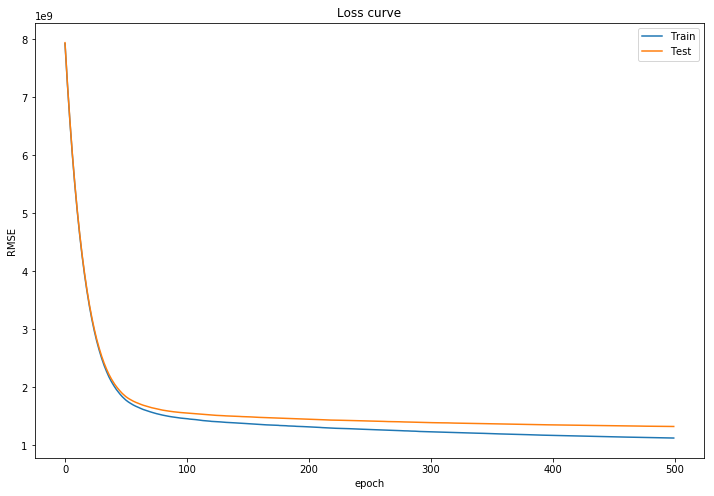

In [90]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Loss curve')
plt.savefig(figure_path + 'no_fertl.png', dpi=500)

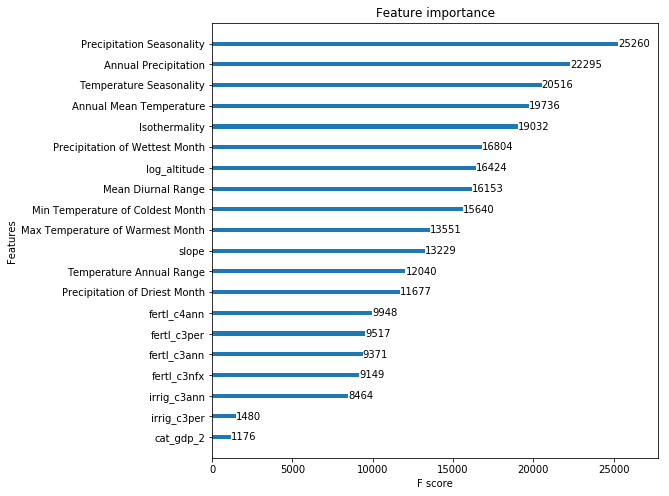

In [91]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax, grid=False, title='Feature importance')
#plt.savefig(figure_path + 'feature_importance_no_irrig.png', dpi=500)
plt.show()

In [119]:
results_df.to_csv('data/models/' + 'model_comparison.csv')

In [124]:
results_df.sort_values(by='Validation_RMSE')

,Model,Validation_R2,Validation_RMSE
1,gdp_continuous,0.919991,1.289891e+09
2,gdp_cat_stat,0.917088,1.313086e+09
7,gdp_cat_income,0.915885,1.322579e+09
6,no_soil,0.915609,1.324750e+09
4,no_irrig,0.915326,1.326963e+09
0,no_gdp,0.915216,1.327830e+09
5,no_fertl,0.901939,1.428014e+09
3,no_climate,0.784823,2.115354e+09


## Final model

In [8]:
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [9]:
df_2000 = pd.read_csv(inputs_path + 'normalized_2000_gdp_cat_new.csv', index_col='pixel_id', na_values=[-9999]).drop(['log_GDP_pc'], axis=1)

### Tune parameters

In [10]:
X, y = df_2000.drop(['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X, label=y)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [13]:
parameters = {'booster': ['gbtree'],
              'objective': ['reg:linear'],
              'n_estimators': [500],
              'learning_rate': [0.01, 0.1, 0.5], 
              'min_split_loss': [0, 0.05, 0.1],
              'max_depth': [5, 10, 15],
              'min_child_weight': [1, 100, 500],
              'subsample': [0.2, 0.5, 1], 
              'colsample_bytree': [0.2, 0.5, 1], 
              'reg_alpha': [0.01, 0.1, 0.5]}

In [25]:
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        parameters1,
                        scoring=['r2', 'neg_mean_squared_log_error'],
                        refit='r2',
                        n_jobs=-1,
                        cv=5, 
                        verbose=2)

In [26]:
xgb_grid.fit(X, y)
pickle.dump(xgb_grid, open('data/models/' + 'test.sav', 'wb'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.0s remaining:   49.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.0s finished
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
xgb_grid_search = pickle.load(open('data/models/' + 'test.sav', 'rb'))
pd.DataFrame.from_dict(xgb_grid_search.cv_results_)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Romain/anaconda/envs/project/lib/python3.6/site-pa

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_nthread,...,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
0,20.904013,0.434567,1.668403,0.559446,0.5,0.03,3,4,5,4,...,-3.504115,0.535657,1,-3.61259,-3.582487,-3.607785,-3.587967,-3.587324,-3.595631,0.012131


In [14]:
xgb_grid = pickle.load(open('data/models/' + 'xgb_grid_search.sav', 'rb'))
pd.DataFrame.from_dict(xgb_grid.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

## Train final model

In [82]:
optimal_params = params
optimal_params

{'colsample_bytree': 0.85,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:linear',
 'silent': 1,
 'reg_alpha': 0.1}

In [83]:
model_name = 'final_1'

In [84]:
X, y = df_2000.drop(['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

In [86]:
col_order = X.columns

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [28]:
try:
    model = pickle.load(open('data/models/' + model_name + '.sav', 'rb'))
except: 
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    pickle.dump(model, open('data/models/' + model_name + '.sav', 'wb'))

/Users/Romain/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:7.92379e+09	validation_1-rmse:7.94302e+09
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.56105e+09	validation_1-rmse:7.57883e+09
[2]	validation_0-rmse:7.21686e+09	validation_1-rmse:7.23489e+09
[3]	validation_0-rmse:6.89045e+09	validation_1-rmse:6.90846e+09
[4]	validation_0-rmse:6.5799e+09	validation_1-rmse:6.59773e+09
[5]	validation_0-rmse:6.28583e+09	validation_1-rmse:6.30399e+09
[6]	validation_0-rmse:6.0089e+09	validation_1-rmse:6.02694e+09
[7]	validation_0-rmse:5.74562e+09	validation_1-rmse:5.76386e+09
[8]	validation_0-rmse:5.49561e+09	validation_1-rmse:5.51419e+09
[9]	validation_0-rmse:5.26089e+09	validation_1-rmse:5.27975e+09
[10]	validation_0-rmse:5.03725e+09	validation_1-rmse:5.05717e+09
[11]	validation_0-rmse:4.82541e+09	validation_1-rmse:4.84532e+09
[12]	validation_0-rmse:4.62406e+09	validation_1-rmse:4.64462e+09
[13]	val

[124]	validation_0-rmse:1.3968e+09	validation_1-rmse:1.50572e+09
[125]	validation_0-rmse:1.39517e+09	validation_1-rmse:1.50457e+09
[126]	validation_0-rmse:1.3942e+09	validation_1-rmse:1.5038e+09
[127]	validation_0-rmse:1.39282e+09	validation_1-rmse:1.50266e+09
[128]	validation_0-rmse:1.39162e+09	validation_1-rmse:1.50166e+09
[129]	validation_0-rmse:1.39034e+09	validation_1-rmse:1.50072e+09
[130]	validation_0-rmse:1.38852e+09	validation_1-rmse:1.49938e+09
[131]	validation_0-rmse:1.38758e+09	validation_1-rmse:1.49867e+09
[132]	validation_0-rmse:1.38678e+09	validation_1-rmse:1.49818e+09
[133]	validation_0-rmse:1.38548e+09	validation_1-rmse:1.49728e+09
[134]	validation_0-rmse:1.38486e+09	validation_1-rmse:1.49685e+09
[135]	validation_0-rmse:1.38343e+09	validation_1-rmse:1.49569e+09
[136]	validation_0-rmse:1.38273e+09	validation_1-rmse:1.49514e+09
[137]	validation_0-rmse:1.38213e+09	validation_1-rmse:1.49471e+09
[138]	validation_0-rmse:1.38119e+09	validation_1-rmse:1.49402e+09
[139]	validat

[249]	validation_0-rmse:1.27002e+09	validation_1-rmse:1.41131e+09
[250]	validation_0-rmse:1.26978e+09	validation_1-rmse:1.41116e+09
[251]	validation_0-rmse:1.26878e+09	validation_1-rmse:1.41044e+09
[252]	validation_0-rmse:1.26806e+09	validation_1-rmse:1.40991e+09
[253]	validation_0-rmse:1.26782e+09	validation_1-rmse:1.40978e+09
[254]	validation_0-rmse:1.2664e+09	validation_1-rmse:1.40881e+09
[255]	validation_0-rmse:1.26622e+09	validation_1-rmse:1.40872e+09
[256]	validation_0-rmse:1.2658e+09	validation_1-rmse:1.40842e+09
[257]	validation_0-rmse:1.26449e+09	validation_1-rmse:1.40746e+09
[258]	validation_0-rmse:1.2619e+09	validation_1-rmse:1.40563e+09
[259]	validation_0-rmse:1.26138e+09	validation_1-rmse:1.40526e+09
[260]	validation_0-rmse:1.26094e+09	validation_1-rmse:1.40486e+09
[261]	validation_0-rmse:1.26086e+09	validation_1-rmse:1.40482e+09
[262]	validation_0-rmse:1.25979e+09	validation_1-rmse:1.40392e+09
[263]	validation_0-rmse:1.25912e+09	validation_1-rmse:1.40342e+09
[264]	validat

[374]	validation_0-rmse:1.18144e+09	validation_1-rmse:1.35154e+09
[375]	validation_0-rmse:1.18115e+09	validation_1-rmse:1.35132e+09
[376]	validation_0-rmse:1.18075e+09	validation_1-rmse:1.35113e+09
[377]	validation_0-rmse:1.18047e+09	validation_1-rmse:1.35093e+09
[378]	validation_0-rmse:1.17975e+09	validation_1-rmse:1.35042e+09
[379]	validation_0-rmse:1.17896e+09	validation_1-rmse:1.35007e+09
[380]	validation_0-rmse:1.17753e+09	validation_1-rmse:1.34936e+09
[381]	validation_0-rmse:1.17744e+09	validation_1-rmse:1.34932e+09
[382]	validation_0-rmse:1.17716e+09	validation_1-rmse:1.34914e+09
[383]	validation_0-rmse:1.17703e+09	validation_1-rmse:1.34906e+09
[384]	validation_0-rmse:1.17612e+09	validation_1-rmse:1.34843e+09
[385]	validation_0-rmse:1.17505e+09	validation_1-rmse:1.34779e+09
[386]	validation_0-rmse:1.17442e+09	validation_1-rmse:1.34749e+09
[387]	validation_0-rmse:1.17424e+09	validation_1-rmse:1.34738e+09
[388]	validation_0-rmse:1.17402e+09	validation_1-rmse:1.3472e+09
[389]	valid

[499]	validation_0-rmse:1.11566e+09	validation_1-rmse:1.31306e+09


In [29]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')
rmse = mean_squared_error(y_test, y_pred)**(1/2)

R2 score: 0.9170881085028902


In [30]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

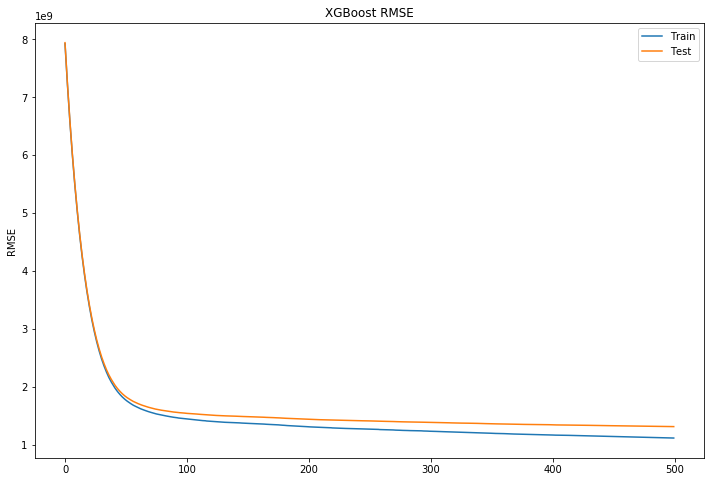

In [31]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

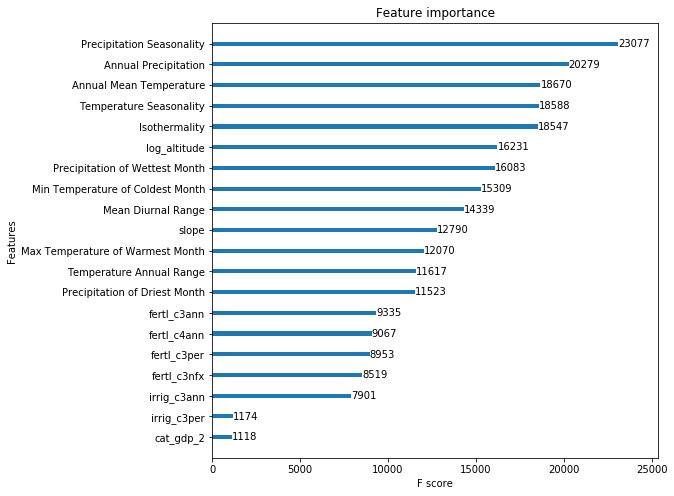

In [32]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax, grid=False, title='Feature importance')
plt.show()

## 2050 predictions

### Predict scenarios

In [70]:
model_name = 'final_1'
model = pickle.load(open('data/models/' + model_name + '.sav', 'rb'))

In [71]:
files_2050 = os.listdir(inputs_path)
files_2050 = [filename for filename in files_2050 if 'ssp' in filename]

climate_models, climate_scenarios = [], []

for file in files_2050:
    if len(file) == 11:
        climate_models.append(file[:2])
        climate_scenarios.append(file[3:7])

climate_models = list(set(climate_models))
climate_models.sort()
climate_scenarios = list(set(climate_scenarios))
climate_scenarios.sort()
climate_models, climate_scenarios

(['cc', 'gs', 'he', 'mr'], ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5'])

In [89]:
for climate_model in climate_models:
    print(climate_model)
    for ssp in climate_scenarios:
        print(ssp)
        print('Loading data')
        df = pd.read_csv(intermediate_path + 'based2000_clustered_{}_{}_gdp_cat_new.csv'.format(climate_model, ssp), index_col='pixel_id', na_values=[-9999]).drop(['log_GDP_pc', 'label_10'], axis=1)
        
        for col in non_numerical_col_2:
            df[col] = df[col] - df[col].min()
            df[col] = df[col] / df[col].max()
            
        pred_inp = pd.get_dummies(df, columns=non_numerical_col)
        
        new_cols = pred_inp.columns
        # Add missing columns set to 0 everywhere (some gdp categories)
        for col in col_order:
            if col not in new_cols:
                pred_inp[col] = 0
        
        print('Predicting future yields')
        df['calories_per_ha'] = model.predict(pred_inp[col_order])
        print('Saving output')
        df.to_csv(output_data + '{}_{}_2050.csv'.format(climate_model, ssp))

cc
ssp1
Loading data


/Users/Romain/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Predicting future yields
Saving output
ssp2
Loading data
Predicting future yields
Saving output
ssp3
Loading data
Predicting future yields
Saving output
ssp4
Loading data
Predicting future yields
Saving output
ssp5
Loading data
Predicting future yields
Saving output
gs
ssp1
Loading data
Predicting future yields
Saving output
ssp2
Loading data
Predicting future yields
Saving output
ssp3
Loading data
Predicting future yields
Saving output
ssp4
Loading data
Predicting future yields
Saving output
ssp5
Loading data
Predicting future yields
Saving output
he
ssp1
Loading data
Predicting future yields
Saving output
ssp2
Loading data
Predicting future yields
Saving output
ssp3
Loading data
Predicting future yields
Saving output
ssp4
Loading data
Predicting future yields
Saving output
ssp5
Loading data
Predicting future yields
Saving output
mr
ssp1
Loading data
Predicting future yields
Saving output
ssp2
Loading data
Predicting future yields
Saving output
ssp3
Loading data
Predicting future yiel

### Aggregate climate models

In [ ]:
for ssp in climate_scenarios:
    print('Aggregating: {}'.format(climate_model))
    data = []
    for climate_model in climate_models:
        df = pd.read_csv(output_data + '{}_{}_2050.csv'.format(climate_model, ssp), index_col='pixel_id', na_values=[-9999])
        data.append(df)
    
    for df in data:
        

## Geographical analysis

In [23]:
def visualize_predictions(caloric_yield, scenario, min_val, max_val, fig, ax, title, shape=(2160, 4320), savefig=False):
    
    # Set values to 
    yield_array = np.zeros((shape[0]*shape[1],))
    yield_array[caloric_yield.index] = caloric_yield.values
    yield_df = pd.DataFrame(yield_array, columns=['label'])
    
    #cmap = cm.RdYlGn
    cmap = cm.bwr_r
    
    #Plot data
    data = yield_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, vmin=min_val, vmax=max_val, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
        
    ax.set_title(title)
    cb = fig.colorbar(im, ax=ax)
    cb.set_label('Calories per hectare')
  
    if savefig != False:
        fig.savefig(output_data + 'figures/' + scenario[0] + '_' + scenario[1] + '.png', dpi=500)



In [12]:
climate_model = 'cc'
ssp = 'SSP1'

df = pd.read_csv(output_data + '{}_{}_2050.csv'.format(climate_model, ssp), index_col='pixel_id', na_values=[-9999])

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


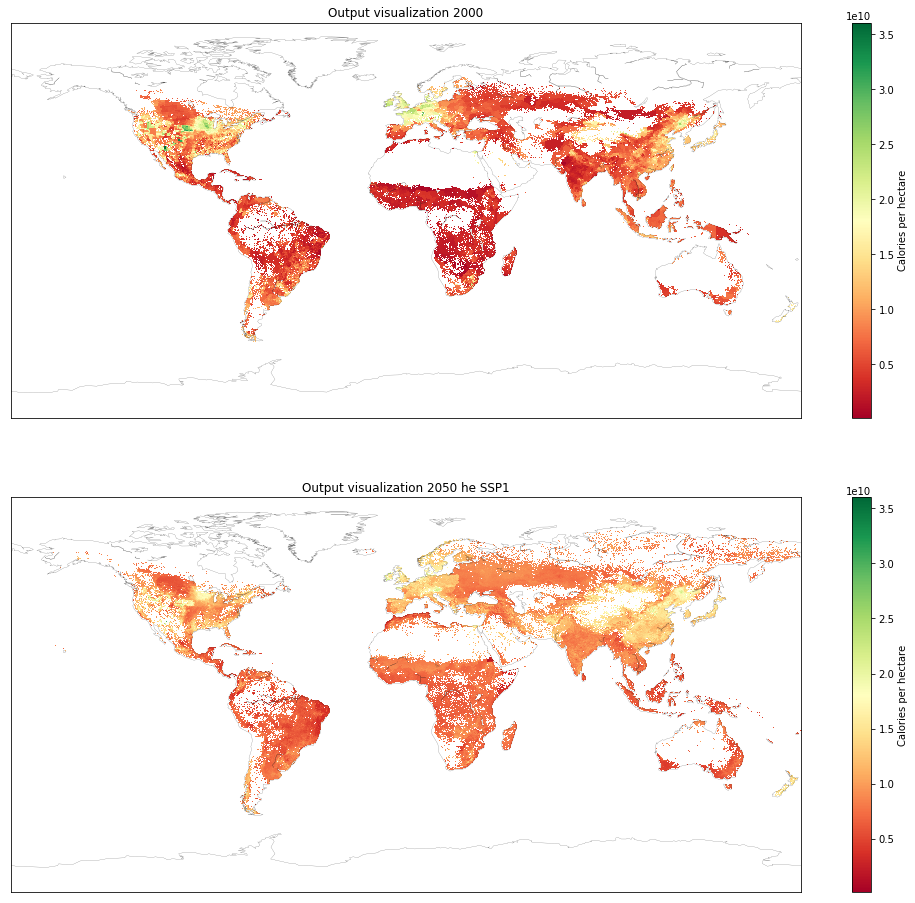

In [123]:
fig, ax = plt.subplots(2, 1, figsize=(18, 16))

min_val = min([min(df_2000['calories_per_ha']), min(df['calories_per_ha'])])
max_val = max([max(df_2000['calories_per_ha']), max(df['calories_per_ha'])])

title_2000 = 'Output visualization 2000'
visualize_predictions(df_2000['calories_per_ha'], [climate_model, ssp], min_val, max_val, fig, ax[0], title_2000, savefig=False)

title = 'Output visualization 2050 {} {}'.format(climate_model, ssp)
visualize_predictions(df['calories_per_ha'], [climate_model, ssp], min_val, max_val, fig, ax[1], title, savefig=False)

plt.savefig(output_data + 'figures/' + 'test.png', dpi=500)

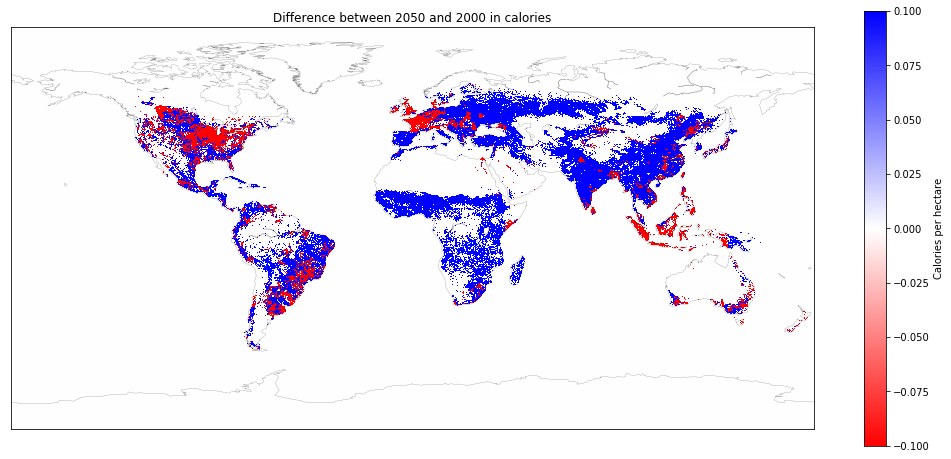

In [24]:
diff = df['calories_per_ha'] - df_2000['calories_per_ha']

fig, ax = plt.subplots(figsize=(18, 8))

min_val = min(diff)
max_val = max(diff)

title = 'Difference between 2050 and 2000 in calories'
visualize_predictions(diff, [], min_val, max_val, fig, ax, title, savefig=False)

plt.savefig(output_data + 'figures/' + 'test_diff.png', dpi=500)

In [26]:
diff

pixel_id
776595              NaN
780822              NaN
780823              NaN
780827              NaN
780915              NaN
780920              NaN
780980              NaN
780999              NaN
781000              NaN
781034              NaN
781036              NaN
781039              NaN
785130              NaN
785132              NaN
785134              NaN
785197              NaN
785223              NaN
785227              NaN
785241              NaN
785273              NaN
785279              NaN
785280              NaN
785282              NaN
785286              NaN
785324              NaN
785348              NaN
785358              NaN
789445              NaN
789446              NaN
789447              NaN
               ...     
7526763             NaN
7526764             NaN
7526765             NaN
7526766             NaN
7526767             NaN
7526768             NaN
7526771             NaN
7526772   -3.575093e+09
7526773   -3.494136e+09
7526775             NaN
7526776

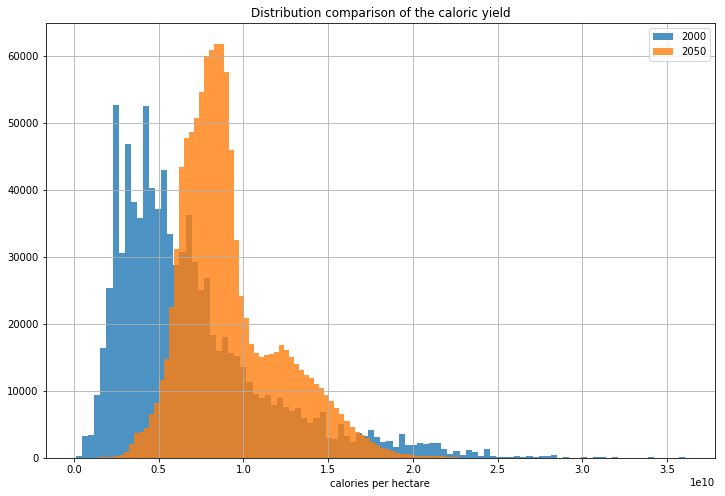

In [157]:
plt.figure(figsize=(12, 8))
df_2000['calories_per_ha'].hist(bins=100, alpha=0.8, label='2000')
df['calories_per_ha'].hist(bins=100, alpha=0.8, label='2050')
plt.title('Distribution comparison of the caloric yield')
plt.xlabel('calories per hectare')
plt.legend()
plt.savefig(output_data + 'figures/' + 'dist_comp.png', dpi=500)

## Sensitivity to different features

In [14]:
len(df)

1060827

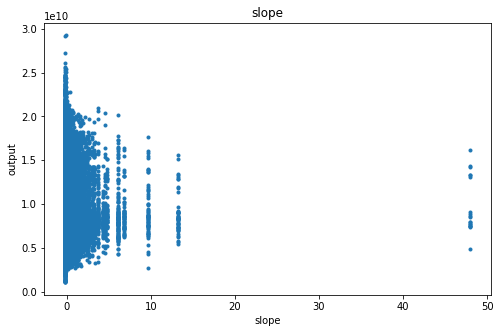

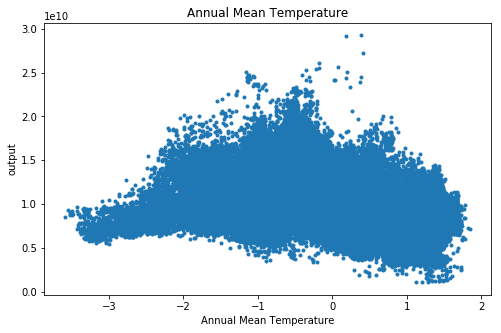

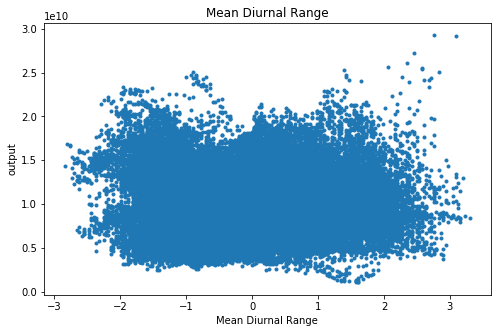

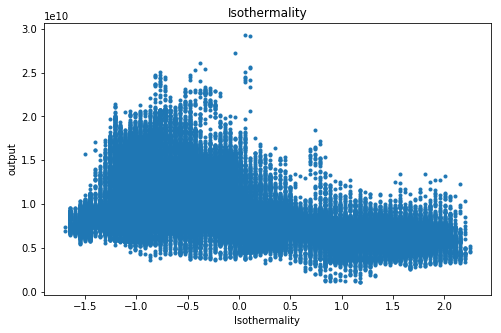

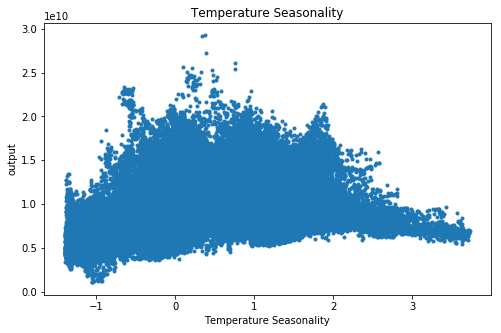

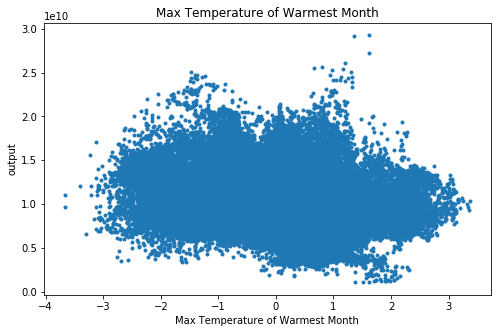

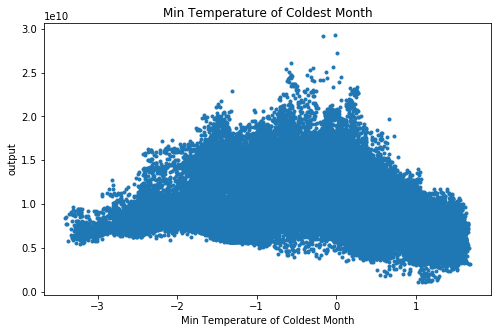

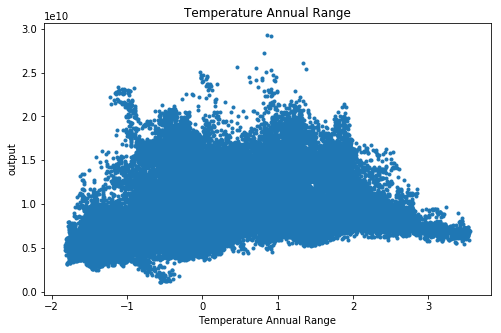

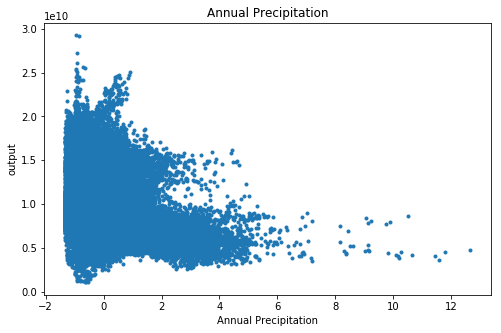

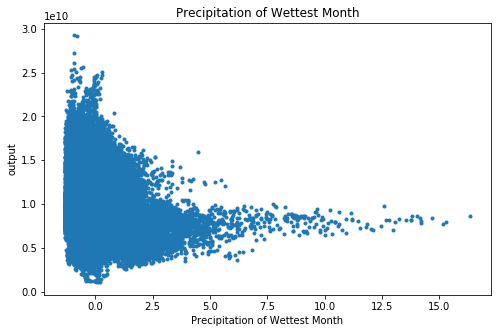

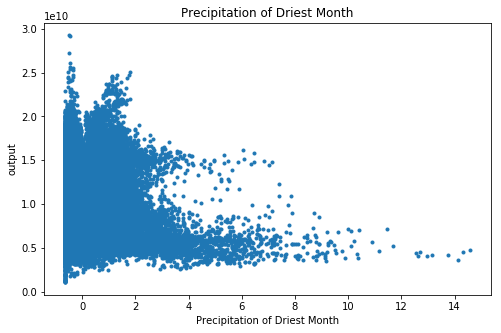

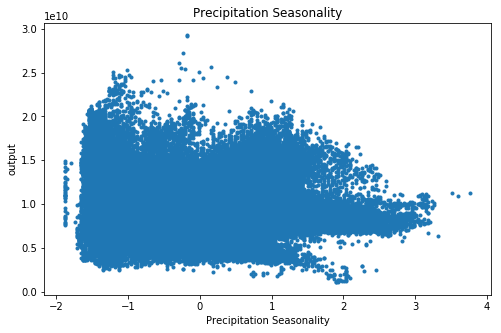

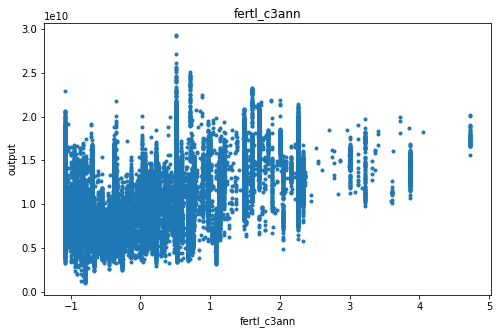

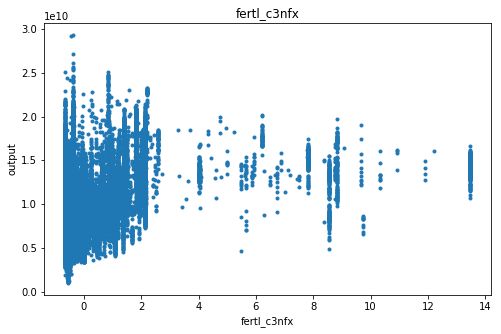

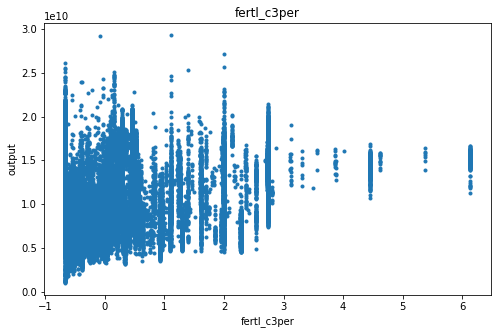

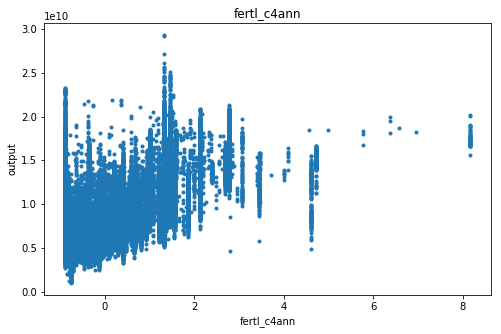

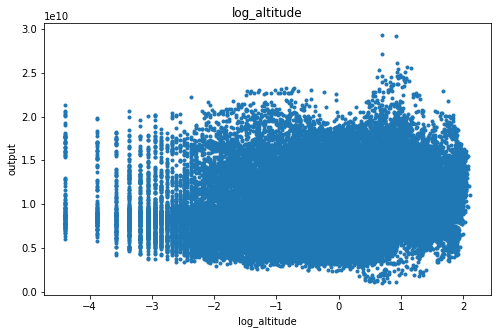

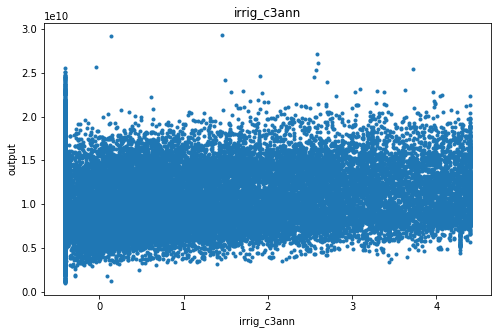

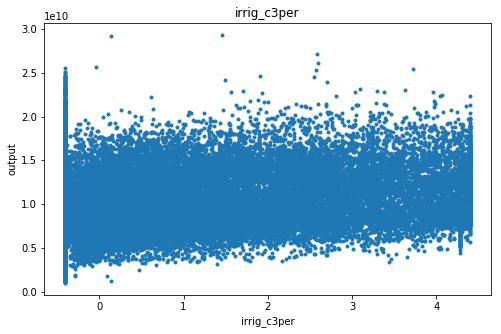

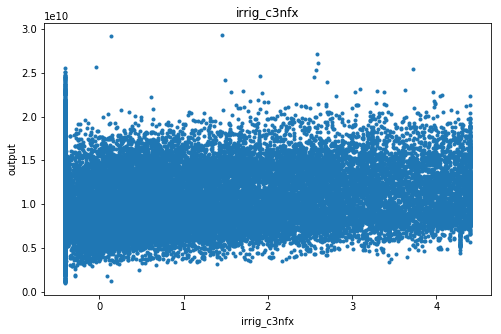

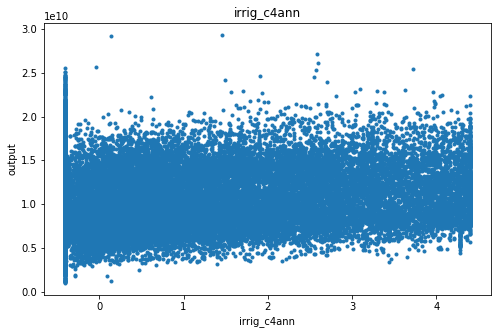

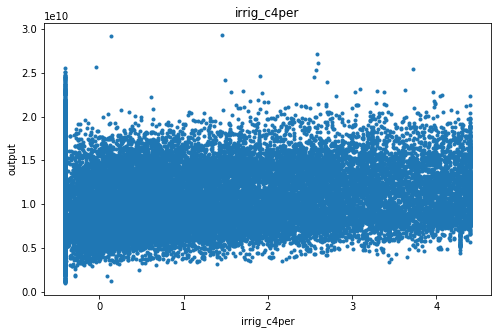

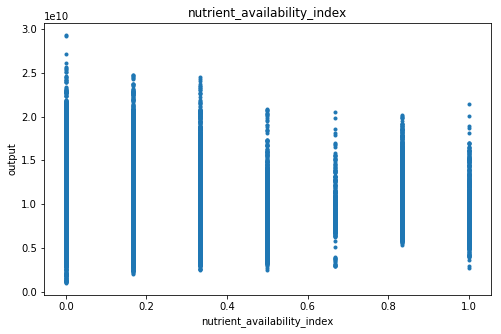

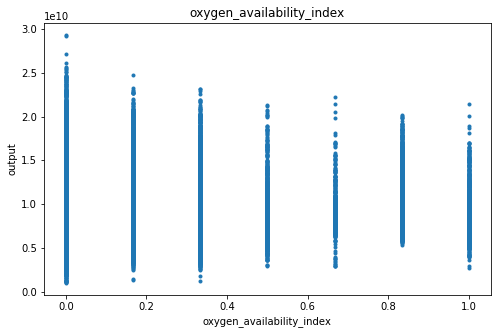

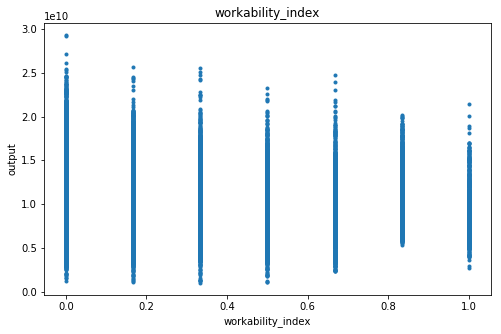

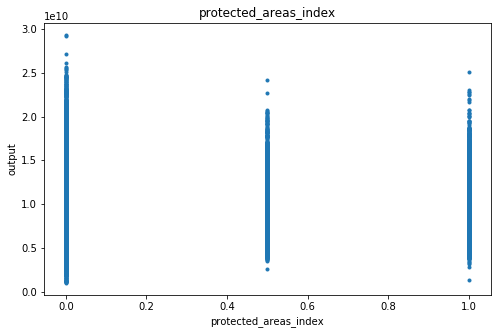

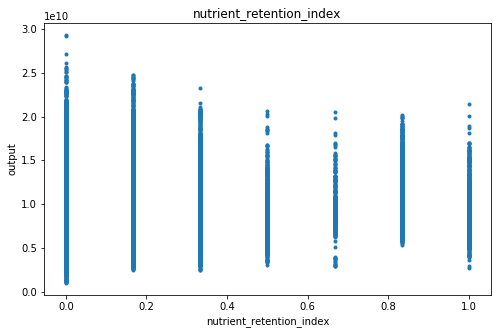

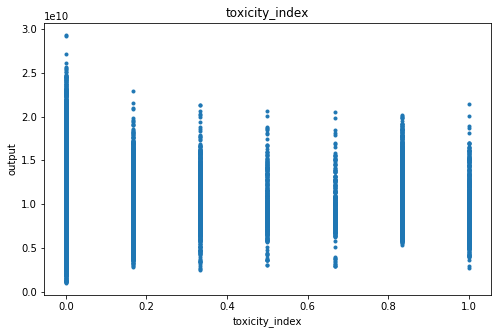

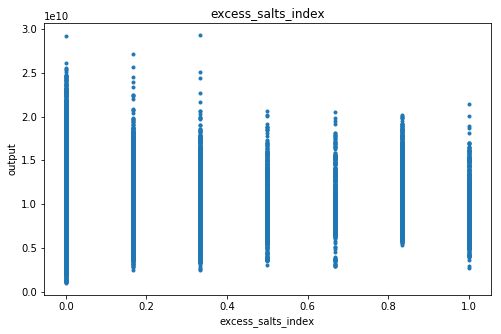

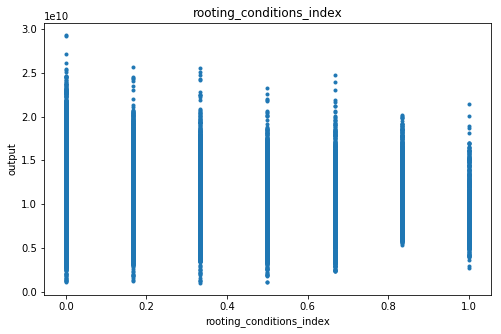

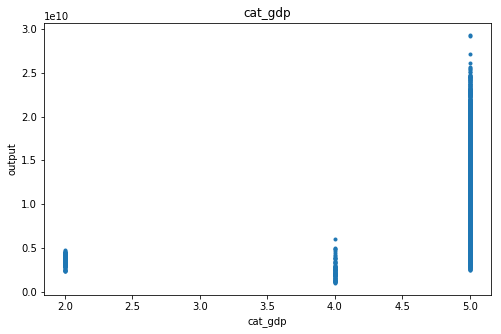

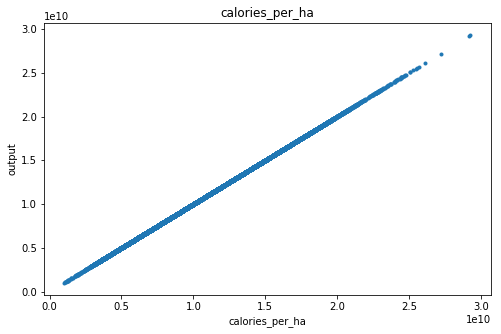

In [20]:
sample = df.sample(n=100000)
for feature in sample.columns:
    plt.figure(figsize=(8, 5))
    plt.xlabel(feature)
    plt.ylabel('output')
    plt.title(feature)
    plt.scatter(sample[feature], sample['calories_per_ha'], marker='.')

## Tests

In [ ]:
df_2000 = pd.read_csv(inputs_path + 'normalized_2000_gdp_cat.csv', index_col='pixel_id', na_values=[-9999]).drop(['log_GDP_pc'], axis=1)

In [ ]:
df_2000.head()

In [ ]:
X, y = df_2000.drop(['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
params = {'objective': 'reg:linear', 'colsample_bytree': 0.85, 'learning_rate': 0.04, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4, 'verbosity': 2}

In [ ]:
model_test = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)

In [ ]:
model_test.tail(10)

In [ ]:
y.hist()

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.lineplot(data=model_test['train-rmse-mean'])
#sns.lineplot(data=model_test[])

plt.subplot(122)
sns.lineplot(data=model_test['test-rmse-mean'])
#sns.lineplot(data=model_test[])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [ ]:
xg_reg = xgb.XGBRegressor(params=params)

In [ ]:
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xg_reg, num_trees=0, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xg_reg, ax=ax)
plt.show()

In [ ]:
df_2000_with_full_gdp = pd.read_csv(inputs_path + 'normalized_2000.csv', index_col='pixel_id', na_values=[-9999])

In [ ]:
df_2000_with_full_gdp.head()

In [ ]:
X_with_full_gdp, y_with_full_gdp = df_2000.drop(['calories_per_ha'], axis=1), df_2000['calories_per_ha']
col2 = non_numerical_col.copy()
col2.remove('cat_gdp')
X_with_full_gdp = pd.get_dummies(X_with_full_gdp, columns=col2).drop(['cat_gdp'], axis=1)

data_dmatrix_2 = xgb.DMatrix(data=X_with_full_gdp,label=y_with_full_gdp)

In [ ]:
X_train_with_full_gdp, X_test_with_full_gdp, y_train_with_full_gdp, y_test_with_full_gdp = train_test_split(X_with_full_gdp, y_with_full_gdp, test_size=0.1, random_state=123)

In [ ]:
model_test2 = xgb.cv(dtrain=data_dmatrix_2, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)

In [ ]:
model_test2.tail(10)

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.lineplot(data=model_test2['train-rmse-mean'])
#sns.lineplot(data=model_test[])

plt.subplot(122)
sns.lineplot(data=model_test2['test-rmse-mean'])
#sns.lineplot(data=model_test[])

In [ ]:
xg_reg2 = xgb.XGBRegressor(params=params)

In [ ]:
xg_reg2.fit(X_train_with_full_gdp, y_train_with_full_gdp)

preds2 = xg_reg2.predict(X_test_with_full_gdp)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xg_reg2, num_trees=0, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xg_reg2, ax=ax)
plt.show()

In [ ]:
test = pd.read_csv(inputs_path + 'cc_ssp1_gdp_cat.csv', index_col='pixel_id', na_values=[-9999]).drop(['lat', '%cropland', 'lon', 'log_GDP_pc'], axis=1)

In [ ]:
test.head()